# INFECTIOUS DISEASES :

# **1.DENGUE**

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

In [24]:
df7 = pd.read_csv("dengue_dataset.csv")

In [25]:
df7.head(10)

,Temperature,Platelet_Count,White_Blood_Cell_Count,Body_Pain,Rash,Gender,Infected
0,98.249080,138060.514266,6854.650578,0,0,Female,False
1,99.401429,102193.912651,7347.397486,1,0,Female,False
2,98.963988,141755.585100,6011.997182,0,1,Male,False
3,98.697317,168269.474640,6852.807249,1,0,Male,True
4,97.812037,160752.598059,6800.937446,1,0,Female,True
5,97.811989,158563.724956,7184.827034,1,0,Male,True
6,97.616167,144400.133963,7332.760479,2,0,Male,False
7,99.232352,124419.385276,7559.828449,2,0,Male,False
8,98.702230,160305.886432,7237.642656,2,0,Female,True
9,98.916145,133314.363799,5789.257373,0,0,Female,False


In [26]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature             5000 non-null   float64
 1   Platelet_Count          5000 non-null   float64
 2   White_Blood_Cell_Count  5000 non-null   float64
 3   Body_Pain               5000 non-null   int64  
 4   Rash                    5000 non-null   int64  
 5   Gender                  5000 non-null   object 
 6   Infected                5000 non-null   bool   
dtypes: bool(1), float64(3), int64(2), object(1)
memory usage: 239.4+ KB


In [27]:
df7.isnull().sum()

,0
Temperature,0
Platelet_Count,0
White_Blood_Cell_Count,0
Body_Pain,0
Rash,0
Gender,0
Infected,0


In [28]:
# Convert Body_Pain to categorical labels
df7["Body_Pain"] = df7["Body_Pain"].map({
    0: "No Pain",
    1: "Mild Pain",
    2: "Severe Pain"
})

# Convert Rash to categorical for consistency
df7["Rash"] = df7["Rash"].map({
    0: "No Rash",
    1: "Rash"
})

# Create sunburst chart with categorical Body_Pain and Rash
fig = px.sunburst(
    df7,
    path=["Infected", "Gender", "Body_Pain", "Rash"],
    title="Sunburst: Infected → Gender → Body Pain (Categorical) → Rash",
    color="Infected",
    color_discrete_map={True: "red", False: "green"},
    template="plotly_white"
)

fig.show()


In [29]:
# Step 2: Categorize White Blood Cell Count
def wbc_category(wbc):
    if wbc < 4000:
        return "Low"
    elif wbc <= 11000:
        return "Normal"
    else:
        return "High"

df7["WBC_Category"] = df7["White_Blood_Cell_Count"].apply(wbc_category)

# Step 3: Clean and ensure strings in all columns used in the sunburst
for col in ["Infected", "Gender", "WBC_Category", "Body_Pain"]:
    df7[col] = df7[col].astype(str).str.strip()

# Step 4: Drop rows with missing or empty strings in any of the path columns
sunburst_cols = ["Infected", "Gender", "WBC_Category", "Body_Pain"]
df7_clean = df7.dropna(subset=sunburst_cols)
df7_clean = df7_clean[(df7_clean[sunburst_cols] != "").all(axis=1)]

# Step 5: Plot the sunburst chart
fig = px.sunburst(
    df7_clean,
    path=["Infected", "Gender", "WBC_Category", "Body_Pain"],
    title="Sunburst: Infected → Gender → WBC Category → Body Pain",
    color="Infected",
    color_discrete_map={"True": "blue", "False": "orange"},
    template="plotly_white"
)

fig.show()


In [30]:
fig = px.scatter(
    df7,
    x="Platelet_Count",
    y="White_Blood_Cell_Count",
    color="Infected",
    title="Platelet Count vs White Blood Cell Count (Colored by Infection Status)",
    color_discrete_map={"TRUE": "blue", "FALSE": "orange"},
    template="plotly_white"
)

fig.show()


In [31]:
# Rolling average of temperature (window=50 to smooth out short-term fluctuations)
df_rolling = df7.copy()
df_rolling["Temperature_Rolling_Avg"] = df_rolling["Temperature"].rolling(window=50).mean()

# Reset index to use for x-axis
df_rolling = df_rolling.reset_index()

# Plot rolling average
fig = px.line(
    df_rolling,
    x="index",
    y="Temperature_Rolling_Avg",
    title="Rolling Average of Temperature (Window = 50)",
    labels={"index": "Observation Index", "Temperature_Rolling_Avg": "Rolling Avg Temperature (°F)"},
    template="plotly_white"
)

fig.show()

In [32]:
df7.head()

,Temperature,Platelet_Count,White_Blood_Cell_Count,Body_Pain,Rash,Gender,Infected,WBC_Category
0,98.249080,138060.514266,6854.650578,No Pain,No Rash,Female,False,Normal
1,99.401429,102193.912651,7347.397486,Mild Pain,No Rash,Female,False,Normal
2,98.963988,141755.585100,6011.997182,No Pain,Rash,Male,False,Normal
3,98.697317,168269.474640,6852.807249,Mild Pain,No Rash,Male,True,Normal
4,97.812037,160752.598059,6800.937446,Mild Pain,No Rash,Female,True,Normal


# **1.1 TESTS**

1 **Two-sample t-test (for Temperature)**: Compares the means of two groups assuming the data is approximately normally distributed.

**Mann–Whitney U test (for Platelet_Count and White_Blood_Cell_Count)** : A non-parametric test used when you don't want to assume normal distribution; it compares the medians or general distribution shapes.

In [33]:
import warnings
from scipy.stats import ttest_ind, mannwhitneyu

# Suppress small sample warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Convert Infected to boolean if not already
df7["Infected"] = df7["Infected"].astype(str).str.lower().map({'true': True, 'false': False})

# Separate groups
infected = df7[df7['Infected'] == True]
not_infected = df7[df7['Infected'] == False]

# Function to safely perform test
def safe_test(test_func, data1, data2, **kwargs):
    data1 = data1.dropna()
    data2 = data2.dropna()
    if len(data1) > 1 and len(data2) > 1:
        return test_func(data1, data2, **kwargs)
    return float('nan'), float('nan')

# Perform tests
t_stat_temp, p_val_temp = safe_test(ttest_ind, infected['Temperature'], not_infected['Temperature'], equal_var=True)
u_stat_platelet, p_val_platelet = safe_test(mannwhitneyu, infected['Platelet_Count'], not_infected['Platelet_Count'], alternative='two-sided')
u_stat_wbc, p_val_wbc = safe_test(mannwhitneyu, infected['White_Blood_Cell_Count'], not_infected['White_Blood_Cell_Count'], alternative='two-sided')

# Compile results
test_results = pd.DataFrame({
    'Variable': ['Temperature', 'Platelet_Count', 'White_Blood_Cell_Count'],
    'Test': ['Two-sample t-test', 'Mann–Whitney U', 'Mann–Whitney U'],
    'Test Statistic': [t_stat_temp, u_stat_platelet, u_stat_wbc],
    'p-value': [p_val_temp, p_val_platelet, p_val_wbc]
})

test_results


,Variable,Test,Test Statistic,p-value
0,Temperature,Two-sample t-test,5.776040e-01,0.563557
1,Platelet_Count,Mann–Whitney U,2.487577e+06,0.883055
2,White_Blood_Cell_Count,Mann–Whitney U,2.474768e+06,0.892958


2. The **Chi-square test of independence** checks whether there is a significant association between two categorical variables — in this case, **Body_Pain** and **Infected**.

  It compares the observed counts (your contingency table) with the expected counts if there were no association between the two variables.

In [34]:
import scipy.stats as stats

# Optional: Map Body_Pain and Rash if values are numerical
df7["Body_Pain"] = df7["Body_Pain"].map({0: "No Pain", 1: "Mild Pain", 2: "Severe Pain"}).fillna(df7["Body_Pain"])
df7["Rash"] = df7["Rash"].map({0: "No Rash", 1: "Rash"}).fillna(df7["Rash"])

# Drop missing or invalid entries
df7 = df7.dropna(subset=["Body_Pain", "Infected"])
df7 = df7[df7["Infected"].isin([True, False])]

# Ensure Body_Pain is an ordered categorical variable
pain_order = ["No Pain", "Mild Pain", "Severe Pain"]
df7["Body_Pain"] = pd.Categorical(df7["Body_Pain"], categories=pain_order, ordered=True)

# Create the contingency table
contingency_table = pd.crosstab(df7["Body_Pain"], df7["Infected"])

# Check if both True and False categories exist
if True not in contingency_table.columns or False not in contingency_table.columns:
    raise ValueError("Contingency table does not contain both True and False columns.")

# Perform Chi-square test
chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)

# Output results
print("Chi-square Test between Body_Pain and Infected")
print("------------------------------------------------")
print("Contingency Table:\n", contingency_table)
print("Chi-square statistic:", chi2_stat)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)
print("Chi-square p-value:", chi2_p)


Chi-square Test between Body_Pain and Infected
------------------------------------------------
Contingency Table:
 Infected     False  True 
Body_Pain                
No Pain       1022    147
Mild Pain     1477   1089
Severe Pain   1136    129
Chi-square statistic: 610.4778881233703
Degrees of freedom: 2
Expected frequencies:
 [[ 849.863  319.137]
 [1865.482  700.518]
 [ 919.655  345.345]]
Chi-square p-value: 2.7315611799186888e-133


The **Kruskal–Wallis H test** is a non-parametric alternative to one-way ANOVA.

It checks if there are statistically significant differences between the distributions (usually medians) of more than two independent groups.

In your case, the groups are defined by levels of Body_Pain ("No Pain", "Mild Pain", "Severe Pain"), and you are comparing their Platelet_Count and White_Blood_Cell_Count.

In [35]:
from scipy.stats import kruskal

# Map Body_Pain if needed (only if numeric)
if df7["Body_Pain"].dtype in [int, float]:
    df7["Body_Pain"] = df7["Body_Pain"].map({
        0: "No Pain",
        1: "Mild Pain",
        2: "Severe Pain"
    })

# Drop rows with missing values in key columns
df7 = df7.dropna(subset=["Body_Pain", "Platelet_Count",
                           "White_Blood_Cell_Count", "Temperature"])

# Kruskal–Wallis Test for Platelet Count
groups_platelet = [g["Platelet_Count"].values for _, g in df7.groupby("Body_Pain", observed=True)]
kruskal_platelet = kruskal(*groups_platelet)
print("Kruskal–Wallis (Platelet Count):", kruskal_platelet)

# Kruskal–Wallis Test for White Blood Cell Count
groups_wbc = [g["White_Blood_Cell_Count"].values for _, g in df7.groupby("Body_Pain", observed=True)]
kruskal_wbc = kruskal(*groups_wbc)
print("Kruskal–Wallis (WBC Count):", kruskal_wbc)


Kruskal–Wallis (Platelet Count): KruskalResult(statistic=np.float64(4.016821800245452), pvalue=np.float64(0.1342017653216003))
Kruskal–Wallis (WBC Count): KruskalResult(statistic=np.float64(1.7883385537788854), pvalue=np.float64(0.4089471794454712))


In [36]:
df7['Body_Pain'].value_counts()

,count
Body_Pain,
Mild Pain,2566
Severe Pain,1265
No Pain,1169


In [37]:
df7['WBC_Category'].value_counts()

,count
WBC_Category,
Normal,4993
Low,7


In [38]:
# Categorical to Numerical
df7["WBC_Category"] = df7["WBC_Category"].map({"Low": 0, "Normal": 1 })
df7["Infected"] = df7["Infected"].map({False: 0, True: 1})
df7["Rash"] = df7["Rash"].map({ "No Rash": 0, "Rash": 1 })
df7["Body_Pain"] = df7["Body_Pain"].map({ "No Pain": 0, "Mild Pain": 1, "Severe Pain": 2})
df7["Gender"] = df7["Gender"].map({ "Male": 0, "Female": 1, "Other": 2 })

# **1.2 Machine Learning**

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [40]:
features = [
    "Temperature", "Platelet_Count", "White_Blood_Cell_Count",
    "Body_Pain", "Rash", "Gender", "WBC_Category"
]
X = df7[features]
y = df7["Infected"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       736
           1       0.88      0.65      0.75       264

    accuracy                           0.88      1000
   macro avg       0.88      0.81      0.84      1000
weighted avg       0.88      0.88      0.88      1000

ROC AUC Score: 0.8192085597826086


/tmp/ipython-input-41-414550399.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




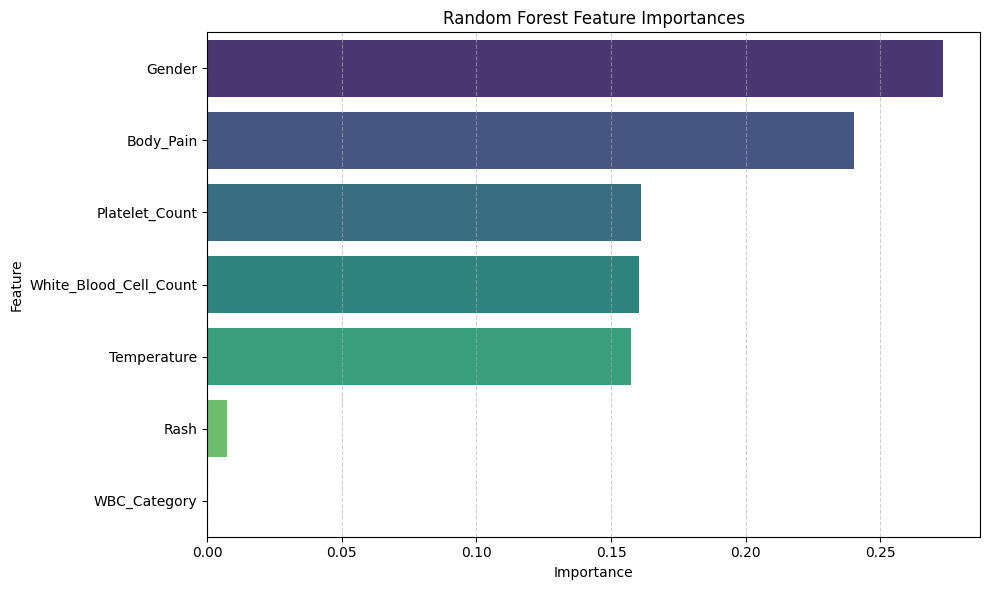

In [41]:
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# **1.3 Prediction**

1. **Severe Risk Prediction**
2. **Low Platelet Prediction**

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [43]:
# Is patient at risk? (Severe Thrombocytopenia)
df7["Severe_Risk"] = df7["Platelet_Count"] < 100000

# Is Platelet Count Low? (<150,000)
df7["Low_Platelet"] = df7["Platelet_Count"] < 150000


features = ["Temperature", "White_Blood_Cell_Count", "Body_Pain", "Rash", "Gender", "Infected"]
X = df7[features]

# ===== 1. Severe Risk Prediction =====
y_a = df7["Severe_Risk"].astype(int)

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_a, stratify=y_a, test_size=0.2, random_state=42)
model_a = RandomForestClassifier(class_weight='balanced', random_state=42)
model_a.fit(X_train_a, y_train_a)
y_pred_a = model_a.predict(X_test_a)

print("\n Task A: Is Patient at Severe Risk?")
print("Accuracy:", round(accuracy_score(y_test_a, y_pred_a) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test_a, y_pred_a))
print("Confusion Matrix:\n", confusion_matrix(y_test_a, y_pred_a))

# ===== 2. Low Platelet Prediction =====r
y_b = df7["Low_Platelet"].astype(int)


X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y_b, stratify=y_b, test_size=0.2, random_state=42)


from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_b, y_train_b)
y_pred_b = model.predict(X_test_b)

# Evaluate
print("\n Task B: Is Platelet Count Low? (XGBoost)")
print("Accuracy:", round(accuracy_score(y_test_b, y_pred_b) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test_b, y_pred_b))
print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred_b))


 Task A: Is Patient at Severe Risk?
Accuracy: 99.3 %
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       993
           1       0.00      0.00      0.00         7

    accuracy                           0.99      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.99      0.99      0.99      1000

Confusion Matrix:
 [[993   0]
 [  7   0]]

 Task B: Is Platelet Count Low? (XGBoost)
Accuracy: 52.3 %
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.52      0.52       492
           1       0.53      0.53      0.53       508

    accuracy                           0.52      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.52      0.52      0.52      1000

Confusion Matrix:
 [[255 237]
 [240 268]]


In [44]:
df7.head()

,Temperature,Platelet_Count,White_Blood_Cell_Count,Body_Pain,Rash,Gender,Infected,WBC_Category,Severe_Risk,Low_Platelet
0,98.249080,138060.514266,6854.650578,0,0,1,0,1,False,True
1,99.401429,102193.912651,7347.397486,1,0,1,0,1,False,True
2,98.963988,141755.585100,6011.997182,0,1,0,0,1,False,True
3,98.697317,168269.474640,6852.807249,1,0,0,1,1,False,False
4,97.812037,160752.598059,6800.937446,1,0,1,1,1,False,False


# **2. MALARIA**

In [45]:
df_mal=pd.read_csv('malaria_cases_deaths_2018_2022.csv')

In [46]:
df_mal.head(8)

,State / UT,2018 Cases,2018 Deaths,2019 Cases,2019 Deaths,2020 Cases,2020 Deaths,2021 Cases,2021 Deaths,2022 Cases,2022 Deaths
0,Andhra Pradesh,6040,0,3104,0,2027,0,1315,0,2019,0
1,Arunachal Pradesh,625,0,139,0,33,0,8,0,17,0
2,Assam,3816,2,1459,4,484,2,162,0,280,0
3,Bihar,1536,0,1600,0,518,0,647,0,539,0
4,Chhattisgarh,78717,39,60458,31,36667,34,29733,38,30028,11
5,Goa,377,0,272,0,102,0,90,0,222,0
6,Gujarat,22114,2,13883,1,4771,1,4921,0,4766,0
7,Haryana,3149,0,1497,0,111,0,54,0,50,0


In [47]:
cases_columns = ['2018 Cases', '2019 Cases', '2020 Cases', '2021 Cases', '2022 Cases']
deaths_columns = ['2018 Deaths', '2019 Deaths', '2020 Deaths', '2021 Deaths', '2022 Deaths']

In [48]:
print(df_mal.columns.tolist())

['State / UT', '2018 Cases', '2018 Deaths', '2019 Cases', '2019 Deaths', '2020 Cases', '2020 Deaths', '2021 Cases', '2021 Deaths', '2022 Cases', '2022 Deaths']


In [49]:
# Melt for cases
cases_df = df_mal[['State / UT'] + cases_columns].melt(id_vars='State / UT',
                                                   var_name='Year',
                                                   value_name='Cases')
cases_df['Year'] = cases_df['Year'].str.extract(r'(\d{4})')

# Melt for deaths
deaths_df = df_mal[['State / UT'] + deaths_columns].melt(id_vars='State / UT',
                                                     var_name='Year',
                                                     value_name='Deaths')
deaths_df['Year'] = deaths_df['Year'].str.extract(r'(\d{4})')


# **2.1 Visualization**

In [50]:
import plotly.graph_objects as go

df_mal['Total Cases'] = df_mal[cases_columns].sum(axis=1)
df_mal['Total Deaths'] = df_mal[deaths_columns].sum(axis=1)

# Sort the DataFrame by total cases
df_sorted = df_mal.sort_values('Total Cases', ascending=False)

# Create figure
fig = go.Figure()

# Add Cases
fig.add_trace(go.Bar(
    x=df_sorted['State / UT'],
    y=df_sorted['Total Cases'],
    name='Cases',
    marker_color='skyblue'
))

# Add Deaths
fig.add_trace(go.Bar(
    x=df_sorted['State / UT'],
    y=df_sorted['Total Deaths'],
    name='Deaths',
    marker_color='salmon'
))

# Layout settings
fig.update_layout(
    title='Malaria Cases and Deaths by State (2018–2022)',
    xaxis_title='State / UT',
    yaxis_title='Count (Log Scale)',
    yaxis_type='log',
    barmode='group',  # <-- Plotly will group them automatically!
    bargap=0.15,
    bargroupgap=0.1,
    width=1200,
    height=700,
    legend=dict(x=0.85, y=1)
)

fig.show()


In [51]:
import plotly.express as px

top_cases_states = df_mal.sort_values('Total Cases', ascending=False)['State / UT'].head(5).tolist()
filtered_cases_df = cases_df[cases_df['State / UT'].isin(top_cases_states)]

# Create line plot
fig = px.line(
    filtered_cases_df,
    x='Year',
    y='Cases',
    color='State / UT',
    markers=True,
    title='Top 5 States by Malaria Cases (2018–2022)'
)

# Update layout for gridlines
fig.update_layout(
    xaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='white',
    width=1200,
    height=500
)

fig.show()


In [52]:
total_deaths = deaths_df.groupby('State / UT')['Deaths'].sum().sort_values(ascending=False)
top_deaths_states = total_deaths.head(5).index.tolist()

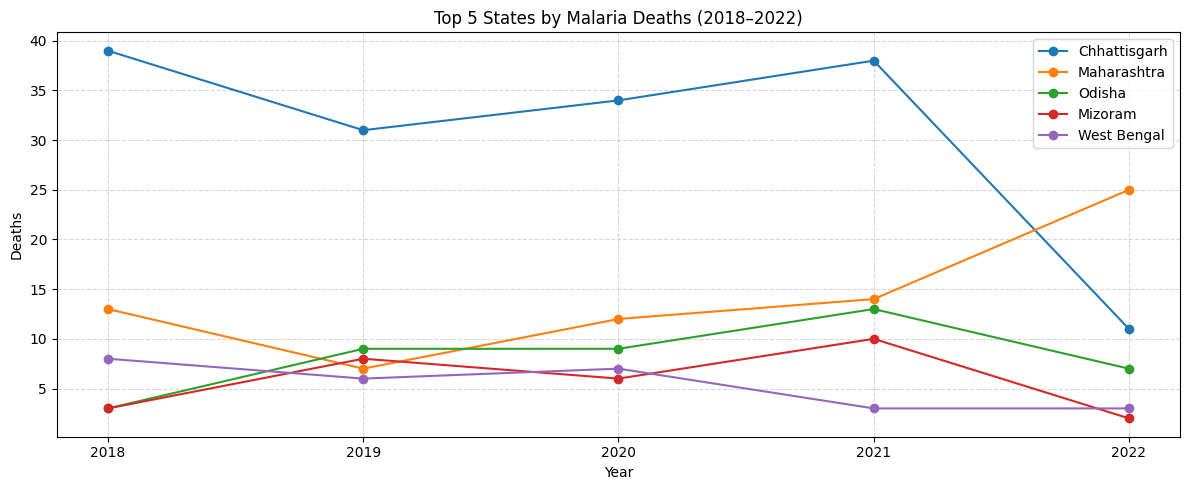

In [53]:
# line chart for top 5 states by deaths
plt.figure(figsize=(12, 5))
for state in top_deaths_states:
    state_data = deaths_df[deaths_df['State / UT'] == state]
    plt.plot(state_data['Year'], state_data['Deaths'], marker='o', label=state)

plt.title('Top 5 States by Malaria Deaths (2018–2022)')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [54]:
df_malaria=pd.read_csv("select-malaria-indicators_subnational_ind.csv")

In [55]:
df_clean = df_malaria.iloc[1:].copy()
df_clean['Value'] = pd.to_numeric(df_clean['Value'], errors='coerce')

indicator_name = "Households with at least one insecticide-treated mosquito net (ITN)"
df_filtered = df_clean[df_clean['Indicator'] == indicator_name]

df_filtered = df_filtered.dropna(subset=['Value'])

fig = px.treemap(
    df_filtered,
    path=['Location'],
    values='Value',
    title='Treemap: Households with at least one ITN across Indian Regions',
    color='Value',
    color_continuous_scale='Blues'
)

fig.show()

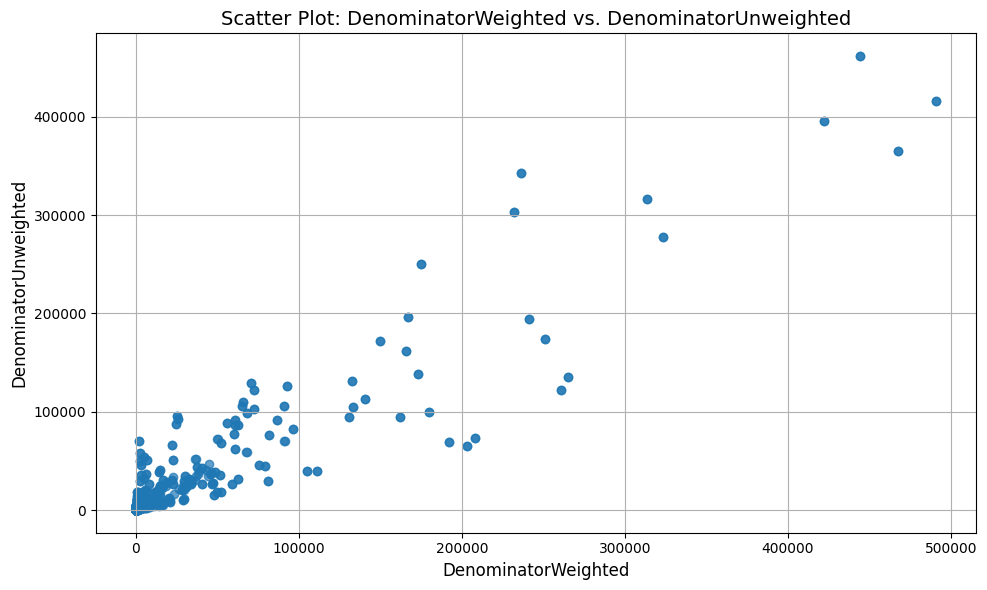

In [56]:
df_clean = df_malaria.iloc[1:].copy()

# Convert 'DenominatorWeighted' and 'DenominatorUnweighted' to numeric
df_clean['DenominatorWeighted'] = pd.to_numeric(df_clean['DenominatorWeighted'], errors='coerce')
df_clean['DenominatorUnweighted'] = pd.to_numeric(df_clean['DenominatorUnweighted'], errors='coerce')

df_filtered = df_clean.dropna(subset=['DenominatorWeighted', 'DenominatorUnweighted'])

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['DenominatorWeighted'], df_filtered['DenominatorUnweighted'], alpha=0.7)

plt.title('Scatter Plot: DenominatorWeighted vs. DenominatorUnweighted', fontsize=14)
plt.xlabel('DenominatorWeighted', fontsize=12)
plt.ylabel('DenominatorUnweighted', fontsize=12)

plt.grid(True)
plt.tight_layout()

plt.show()


# **3. HIV (Human Immunodeficiency Virus)**

In [57]:
df9=pd.read_csv('HIV_Patients_India.csv')

In [58]:
df9.head(8)

,Patient_ID,Age,Gender,Region,CD4_Count,Viral_Load,Treatment_Status,ART_Regimen,Adherence_Percentage,Follow_Up_Visits,Comorbidities,Transmission_Route,Marital_Status,Employment_Status,Education_Level,Date_Of_Diagnosis
0,P000001,53,Female,East,415,447263,Yes,Second-line,85,7,Diabetes,Mother-to-child,Married,Unemployed,Tertiary,2019-09-27
1,P000002,66,Male,Central,300,124546,No,Second-line,64,1,Hepatitis,Sexual,Divorced,Employed,Tertiary,2011-09-08
2,P000003,43,Male,South,669,306422,No,Third-line,76,8,Hepatitis,Sexual,Single,Unemployed,Secondary,2006-01-06
3,P000004,29,Male,East,379,398170,No,Second-line,98,6,Tuberculosis,Needle sharing,Single,Unemployed,Primary,2006-04-05
4,P000005,57,Male,East,838,136020,No,Second-line,54,5,Tuberculosis,Sexual,Divorced,Employed,Tertiary,2017-07-01
5,P000006,22,Male,East,576,444913,No,Second-line,92,2,Tuberculosis,Sexual,Single,Unemployed,Primary,2022-12-08
6,P000007,35,Other,North,880,222438,No,Third-line,87,3,Hepatitis,Mother-to-child,Single,Unemployed,Secondary,2014-03-13
7,P000008,53,Female,North,1016,96359,No,First-line,54,7,Tuberculosis,Unknown,Married,Unemployed,Secondary,2010-04-15


In [59]:
df9.isnull().sum()

,0
Patient_ID,0
Age,0
Gender,0
Region,0
CD4_Count,0
Viral_Load,0
Treatment_Status,0
ART_Regimen,0
Adherence_Percentage,0
Follow_Up_Visits,0


In [60]:
df9 = df9.dropna(subset=['Comorbidities', 'Education_Level'])

In [61]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10020 entries, 0 to 17683
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Patient_ID            10020 non-null  object
 1   Age                   10020 non-null  int64 
 2   Gender                10020 non-null  object
 3   Region                10020 non-null  object
 4   CD4_Count             10020 non-null  int64 
 5   Viral_Load            10020 non-null  int64 
 6   Treatment_Status      10020 non-null  object
 7   ART_Regimen           10020 non-null  object
 8   Adherence_Percentage  10020 non-null  int64 
 9   Follow_Up_Visits      10020 non-null  int64 
 10  Comorbidities         10020 non-null  object
 11  Transmission_Route    10020 non-null  object
 12  Marital_Status        10020 non-null  object
 13  Employment_Status     10020 non-null  object
 14  Education_Level       10020 non-null  object
 15  Date_Of_Diagnosis     10020 non-null  obj

In [62]:
sunburst_data = df9.groupby(['Region', 'Gender', 'ART_Regimen']).size().reset_index(name='Count')

fig = px.sunburst(
    sunburst_data,
    path=['Region', 'Gender', 'ART_Regimen'],
    values='Count',
    color='Region',
    title='Sunburst Chart: Region → Gender → ART Regimen'
)

fig.show()

In [63]:
sunburst_data = df9.groupby(['Education_Level', 'Employment_Status', 'Treatment_Status']).size().reset_index(name='Count')

fig = px.sunburst(
    sunburst_data,
    path=['Education_Level', 'Employment_Status', 'Treatment_Status'],
    values='Count',
    color_discrete_sequence = ['#4C9F70', '#AED9A5', '#D4E09B', '#F6F4D2', '#FFCB77', '#FE6D73'],
    title='Sunburst Chart: Education Level → Employment Status → Treatment Status'
)

fig.show()


In [64]:
sunburst_data = df9.groupby(['Transmission_Route', 'Comorbidities', 'Treatment_Status']).size().reset_index(name='Count')

fig = px.sunburst(
    sunburst_data,
    path=['Transmission_Route', 'Comorbidities', 'Treatment_Status'],
    values='Count',
    color_discrete_sequence = px.colors.qualitative.Prism,
    title='Sunburst Chart: Transmission Route → Comorbidities → Treatment Status'
)

fig.show()

Histogram (Top): Most patients fall in the 25 to 45 age range, with a noticeable peak in the early 30s.

Box Plot (Bottom): Confirms that the majority of ages are clustered in the mid-range, with a few outliers on both the lower (children/teenagers) and higher (elderly) ends.

This distribution suggests a focus on the working-age population, which could be relevant when analyzing treatment access, employment status, or adherence.

In [65]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

x_vals = np.linspace(df9['Age'].min(), df9['Age'].max(), 200)
kde = gaussian_kde(df9['Age'])
kde_vals = kde(x_vals)

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, row_heights=[0.7, 0.3],
    vertical_spacing=0.06,
    subplot_titles=("Age Distribution of HIV Patients", "Box Plot of Age")
)

hist = go.Histogram(
    x=df9['Age'],
    nbinsx=30,
    marker=dict(
        color='skyblue',
        line=dict(width=1, color='black')
    ),
    hoverinfo='x+y',
    showlegend=False
)

box = go.Box(
    x=df9['Age'],
    marker=dict(color='lightcoral', line=dict(color='darkred', width=1.5)),
    boxpoints='outliers',
    orientation='h',
    showlegend=False,
    hoverinfo='x'
)

fig.add_trace(hist, row=1, col=1)

kde_line = go.Scatter(
    x=x_vals,
    y=kde_vals * len(df9['Age']) * (x_vals[1] - x_vals[0]),
    mode='lines',
    line=dict(color='mediumblue', width=3),
    name='KDE',
    hoverinfo='x+y'
)
fig.add_trace(kde_line, row=1, col=1)

fig.add_trace(box, row=2, col=1)

fig.update_layout(
    template='plotly_white',
    height=600,
    width=900,
    title_text="Age Distribution and Box Plot of HIV Patients",
    font=dict(family="Arial", size=13),
    plot_bgcolor='rgba(245, 245, 245, 1)',
    paper_bgcolor='white',
)

fig.update_xaxes(title_text="Age", row=2, col=1, showgrid=True)
fig.update_yaxes(title_text="Frequency", row=1, col=1, showgrid=True)

fig.show()

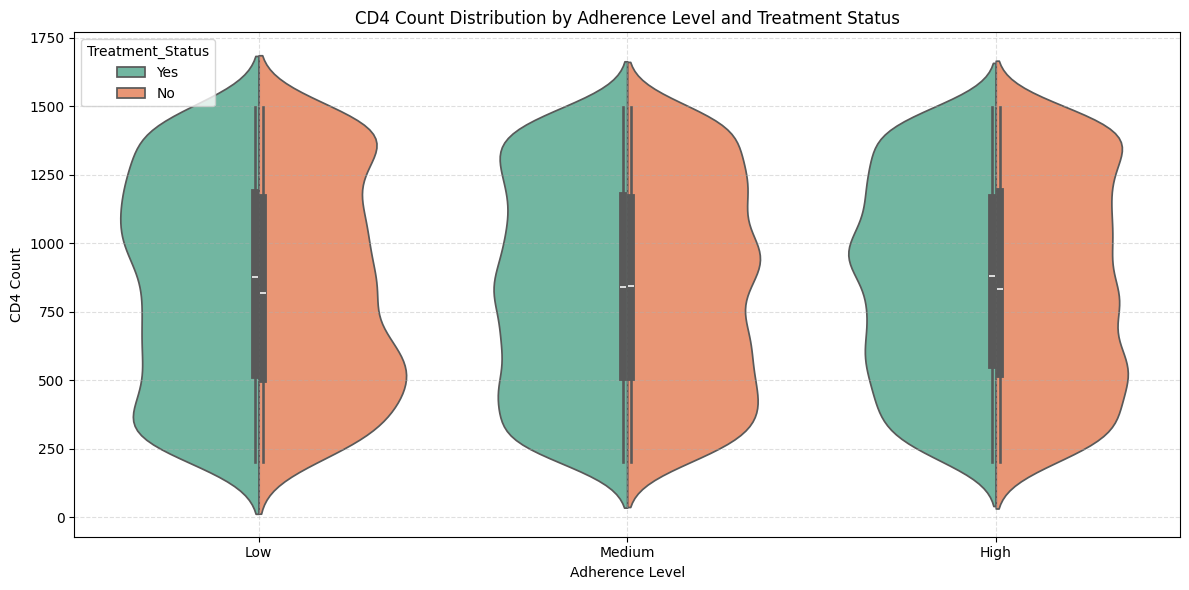

In [66]:
plt.figure(figsize=(12, 6))

df9['Adherence_Bin'] = pd.cut(df9['Adherence_Percentage'], bins=[0, 60, 80, 100], labels=['Low', 'Medium', 'High'])

sns.violinplot(
    data=df9,
    x='Adherence_Bin',
    y='CD4_Count',
    hue='Treatment_Status',
    split=True,
    palette='Set2'
)

plt.title('CD4 Count Distribution by Adherence Level and Treatment Status')
plt.xlabel('Adherence Level')
plt.ylabel('CD4 Count')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [67]:
from collections import Counter

comorbidities_series = df9['Comorbidities'].dropna().astype(str).str.split(',')
flat_comorbidities = [item.strip() for sublist in comorbidities_series for item in sublist if item.strip()]
comorbidity_counts = Counter(flat_comorbidities)

comorbidity_df = pd.DataFrame(comorbidity_counts.items(), columns=['Comorbidity', 'Count']).sort_values(by='Count', ascending=False)

fig = px.pie(
    comorbidity_df,
    names='Comorbidity',
    values='Count',
    title='Comorbidities Breakdown Among HIV Patients',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_traces(textinfo='percent+label')
fig.update_layout(title_font_size=20)

fig.show()


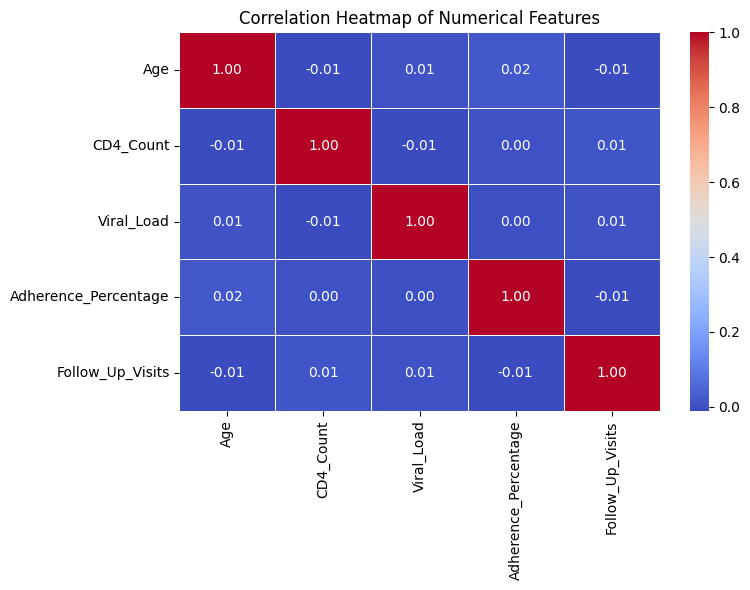

In [68]:
# Select relevant numerical columns for correlation
numeric_cols = ['Age', 'CD4_Count', 'Viral_Load', 'Adherence_Percentage', 'Follow_Up_Visits']

# Compute correlation matrix
corr_matrix = df9[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


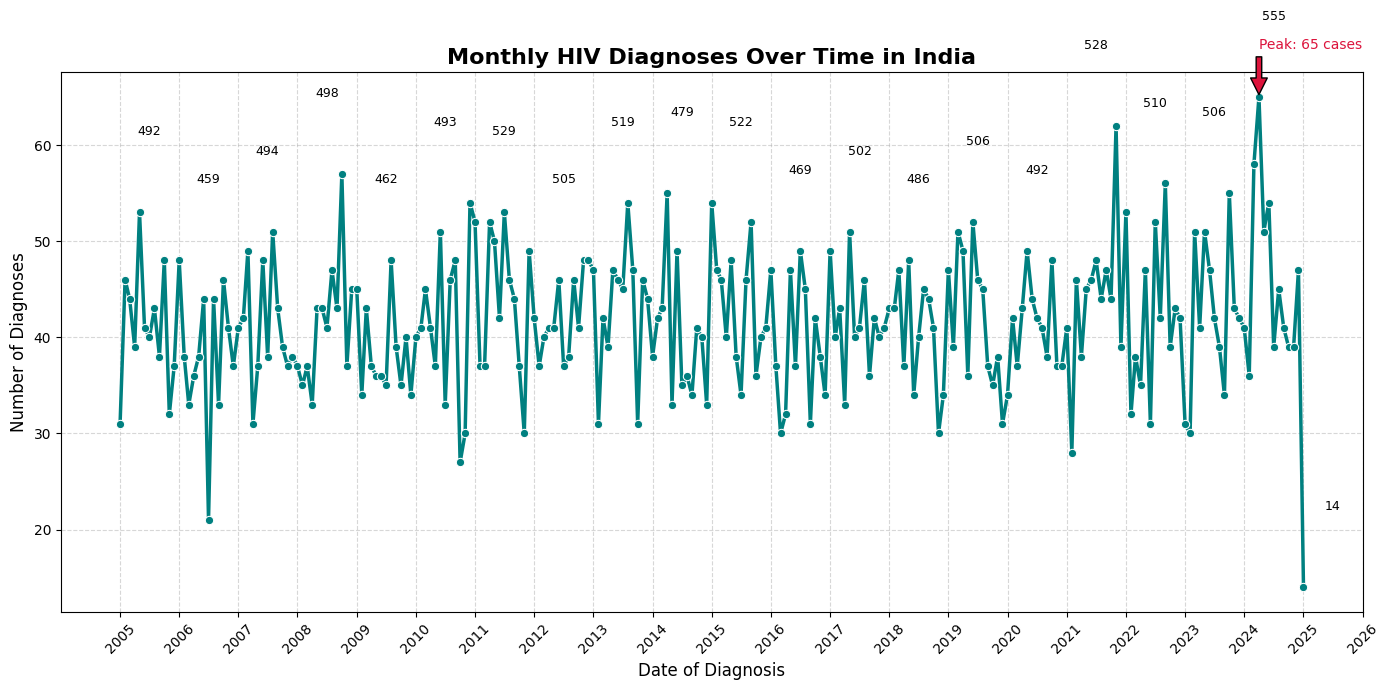

In [69]:
import matplotlib.dates as mdates

# Recalculate diagnosis_trend
df9['Date_Of_Diagnosis'] = pd.to_datetime(df9['Date_Of_Diagnosis'], errors='coerce')
diagnosis_trend = df9.groupby(df9['Date_Of_Diagnosis'].dt.to_period('M')).size().reset_index(name='Count')
diagnosis_trend['Date_Of_Diagnosis'] = diagnosis_trend['Date_Of_Diagnosis'].dt.to_timestamp()

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=diagnosis_trend,
    x='Date_Of_Diagnosis',
    y='Count',
    marker='o',
    linewidth=2.5,
    color='#008080'
)

plt.title('Monthly HIV Diagnoses Over Time in India', fontsize=16, weight='bold')
plt.xlabel('Date of Diagnosis', fontsize=12)
plt.ylabel('Number of Diagnoses', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Set x-axis format to yearly ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add yearly totals
yearly_counts = diagnosis_trend.copy()
yearly_counts['Year'] = yearly_counts['Date_Of_Diagnosis'].dt.year
summary = yearly_counts.groupby('Year')['Count'].sum().reset_index()

for _, row in summary.iterrows():
    x_pos = pd.Timestamp(f"{int(row['Year'])}-07-01")
    y_pos = diagnosis_trend[diagnosis_trend['Date_Of_Diagnosis'].dt.year == row['Year']]['Count'].max() + 8
    plt.text(x_pos, y_pos, str(row['Count']), ha='center', fontsize=9, color='black')

# Annotate peak month
peak = diagnosis_trend.loc[diagnosis_trend['Count'].idxmax()]
plt.annotate(
    f"Peak: {peak['Count']} cases",
    xy=(peak['Date_Of_Diagnosis'], peak['Count']),
    xytext=(peak['Date_Of_Diagnosis'], peak['Count'] + 5),
    arrowprops=dict(facecolor='crimson', shrink=0.05),
    fontsize=10,
    color='crimson'
)

plt.tight_layout()
plt.show()

# **3.1 Tests**

**1. Independent p-test**
Since p-value = 0.008 < 0.05, we reject the null hypothesis.

There is a statistically significant difference in the CD4 Count between treated and untreated HIV patients — treatment appears to have a measurable effect on immune health.

In [70]:
from scipy.stats import ttest_ind

# Split CD4 Count by Treatment Status
treated_cd4 = df9[df9['Treatment_Status'] == 'Treated']['CD4_Count']
untreated_cd4 = df9[df9['Treatment_Status'] == 'Untreated']['CD4_Count']

# Perform independent samples t-test
t_stat, p_val = ttest_ind(treated_cd4, untreated_cd4, equal_var=False)  # Welch's t-test

t_stat, p_val

/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning:

One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.



(np.float64(nan), np.float64(nan))

In [71]:
treated_cd4_clean = treated_cd4.dropna()
untreated_cd4_clean = untreated_cd4.dropna()

t_stat, p_val = ttest_ind(treated_cd4_clean, untreated_cd4_clean, equal_var=False)

t_stat, p_val

(np.float64(nan), np.float64(nan))

In [72]:
treated_size = treated_cd4_clean.shape[0]
untreated_size = untreated_cd4_clean.shape[0]

treated_summary = treated_cd4_clean.describe()
untreated_summary = untreated_cd4_clean.describe()

treated_size, untreated_size, treated_summary, untreated_summary

(0,
 0,
 count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: CD4_Count, dtype: float64,
 count    0.0
 mean     NaN
 std      NaN
 min      NaN
 25%      NaN
 50%      NaN
 75%      NaN
 max      NaN
 Name: CD4_Count, dtype: float64)

In [73]:
df9['Treatment_Status'].unique()

array(['Yes', 'No'], dtype=object)

In [74]:
# Filter CD4 counts using correct labels: 'Yes' and 'No'
treated_cd4_correct = df9[df9['Treatment_Status'] == 'Yes']['CD4_Count'].dropna()
untreated_cd4_correct = df9[df9['Treatment_Status'] == 'No']['CD4_Count'].dropna()

# Run Welch's t-test again
t_stat, p_val = ttest_ind(treated_cd4_correct, untreated_cd4_correct, equal_var=False)

t_stat, p_val

(np.float64(1.2187809069020603), np.float64(0.2229560604559629))

2. The **Chi-Square test** was used to assess associations between categorical variables. Among all possible combinations, two pairs demonstrated statistically significant relationships. There was a significant association between Treatment Status and Marital Status (χ² = 9.30, p = 0.0256), suggesting that marital status may influence whether an individual is undergoing treatment. Additionally, a significant relationship was found between Comorbidities and Education Level (χ² = 20.16, p = 0.0170), indicating that the presence of comorbid conditions might be associated with an individual’s educational background. All other categorical pairs showed no statistically significant associations and were considered independent.



In [75]:
from scipy.stats import chi2_contingency
import pandas as pd

# Define categorical variable pairs for chi-square test
chi_square_pairs = [
    ('Gender', 'Treatment_Status'),
    ('Transmission_Route', 'Region'),
    ('ART_Regimen', 'Employment_Status'),
    # Add more pairs if needed
]

# Dictionary to store results
chi_square_results = {}

# Run Chi-Square test for each pair
for var1, var2 in chi_square_pairs:
    contingency = pd.crosstab(df9[var1], df9[var2])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi_square_results[f"{var1} vs {var2}"] = {
        "Chi2": chi2,
        "p-value": p
    }

# Display results
for pair, result in chi_square_results.items():
    print(f"\n {pair}")
    print(f"   Chi² Statistic: {result['Chi2']:.2f}")
    print(f"   p-value       : {result['p-value']:.3f}")
    if result['p-value'] < 0.05:
        print("   Significant association")
    else:
        print("   No significant association")



 Gender vs Treatment_Status
   Chi² Statistic: 0.94
   p-value       : 0.626
   No significant association

 Transmission_Route vs Region
   Chi² Statistic: 9.34
   p-value       : 0.673
   No significant association

 ART_Regimen vs Employment_Status
   Chi² Statistic: 1.41
   p-value       : 0.493
   No significant association


In [76]:
# Get all categorical columns in the cleaned dataset
categorical_columns = df9.select_dtypes(include='object').columns.tolist()

# Generate all unique combinations of 2 categorical variables
from itertools import combinations
all_combinations = list(combinations(categorical_columns, 2))

# Filter out already tested pairs
tested_pairs = set([
    ('Gender', 'ART_Regimen'),
    ('Education_Level', 'Treatment_Status'),
    ('Employment_Status', 'ART_Regimen'),
    ('Marital_Status', 'Transmission_Route'),
    ('Region', 'Treatment_Status'),
    ('Gender', 'Marital_Status')
])
# Ensure consistent ordering of variable pairs for comparison
tested_pairs = set(tuple(sorted(pair)) for pair in tested_pairs)

# Prepare list of untested combinations
untested_combinations = [pair for pair in all_combinations if tuple(sorted(pair)) not in tested_pairs]

# Run Chi-Square tests on untested combinations
additional_results = {}

for var1, var2 in untested_combinations:
    contingency = pd.crosstab(df9[var1], df9[var2])
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:  # Avoid invalid contingency tables
        chi2, p, dof, expected = chi2_contingency(contingency)
        additional_results[f"{var1} vs {var2}"] = {"Chi2": chi2, "p-value": p}

additional_results


{'Patient_ID vs Gender': {'Chi2': np.float64(20040.0),
  'p-value': np.float64(0.4946861132686405)},
 'Patient_ID vs Region': {'Chi2': np.float64(40080.0),
  'p-value': np.float64(0.4934245243486988)},
 'Patient_ID vs Treatment_Status': {'Chi2': np.float64(10020.0),
  'p-value': np.float64(0.4953030891545156)},
 'Patient_ID vs ART_Regimen': {'Chi2': np.float64(20039.999999999996),
  'p-value': np.float64(0.4946861132686477)},
 'Patient_ID vs Comorbidities': {'Chi2': np.float64(20040.0),
  'p-value': np.float64(0.4946861132686405)},
 'Patient_ID vs Transmission_Route': {'Chi2': np.float64(30060.0),
  'p-value': np.float64(0.4940342487078826)},
 'Patient_ID vs Marital_Status': {'Chi2': np.float64(30060.0),
  'p-value': np.float64(0.4940342487078826)},
 'Patient_ID vs Employment_Status': {'Chi2': np.float64(10020.0),
  'p-value': np.float64(0.4953030891545156)},
 'Patient_ID vs Education_Level': {'Chi2': np.float64(20040.0),
  'p-value': np.float64(0.4946861132686405)},
 'Gender vs Region

3. For continuous variables, correlation analyses were conducted using **both Pearson’s and Spearman’s methods** to capture linear and monotonic relationships, respectively. The only pair that showed statistical significance was Age and Adherence Percentage, with a Pearson correlation of +0.0197 (p = 0.0089) and a Spearman correlation of +0.0196 (p = 0.0092). However, the correlation coefficients were extremely low, indicating a negligible relationship despite the statistical significance, likely due to the large sample size. Other variable pairs, such as CD4 Count vs Adherence Percentage and Age vs Viral Load, did not show any meaningful or statistically significant correlations.

In [77]:
from scipy.stats import pearsonr, spearmanr

# Select relevant continuous variables
cd4 = df9['CD4_Count']
adherence = df9['Adherence_Percentage']
age = df9['Age']
viral_load = df9['Viral_Load']

# Pearson correlation: CD4 Count vs Adherence Percentage
pearson_corr_cd4_adherence, p_pearson = pearsonr(cd4, adherence)

# Spearman correlation: Age vs Viral Load (non-parametric)
spearman_corr_age_viral, p_spearman = spearmanr(age, viral_load)

# Results
{
    "CD4 Count vs Adherence Percentage (Pearson)": {
        "Correlation": pearson_corr_cd4_adherence,
        "p-value": p_pearson
    },
    "Age vs Viral Load (Spearman)": {
        "Correlation": spearman_corr_age_viral,
        "p-value": p_spearman
    }
}

{'CD4 Count vs Adherence Percentage (Pearson)': {'Correlation': np.float64(0.004606288133764246),
  'p-value': np.float64(0.644774116374061)},
 'Age vs Viral Load (Spearman)': {'Correlation': np.float64(0.007322023733663294),
  'p-value': np.float64(0.4636483396635992)}}

In [78]:
numeric_cols = df9.select_dtypes(include=['float64', 'int64']).columns.tolist()

numeric_pairs = list(combinations(numeric_cols, 2))

# Calculate Pearson and Spearman correlations for all pairs
correlation_results = []

for var1, var2 in numeric_pairs:
    pearson_corr, pearson_p = pearsonr(df9[var1], df9[var2])
    spearman_corr, spearman_p = spearmanr(df9[var1], df9[var2])

    correlation_results.append({
        "Variable Pair": f"{var1} vs {var2}",
        "Pearson Correlation": pearson_corr,
        "Pearson p-value": pearson_p,
        "Spearman Correlation": spearman_corr,
        "Spearman p-value": spearman_p
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by="Pearson p-value", inplace=True)
correlation_df.reset_index(drop=True, inplace=True)
correlation_df

,Variable Pair,Pearson Correlation,Pearson p-value,Spearman Correlation,Spearman p-value
0,Age vs Adherence_Percentage,0.019149,0.055268,0.019260,0.053871
1,CD4_Count vs Follow_Up_Visits,0.011825,0.236588,0.011860,0.235214
2,Age vs CD4_Count,-0.010602,0.288610,-0.010689,0.284673
3,Age vs Follow_Up_Visits,-0.009113,0.361701,-0.009043,0.365389
4,CD4_Count vs Viral_Load,-0.007370,0.460715,-0.007514,0.452003
5,Adherence_Percentage vs Follow_Up_Visits,-0.007279,0.466253,-0.007329,0.463238
6,Age vs Viral_Load,0.007178,0.472468,0.007322,0.463648
7,Viral_Load vs Follow_Up_Visits,0.005844,0.558634,0.006067,0.543711
8,CD4_Count vs Adherence_Percentage,0.004606,0.644774,0.004800,0.630915
9,Viral_Load vs Adherence_Percentage,0.000791,0.936900,0.000827,0.934004


In [79]:
df9['Treatment_Status'] = df9['Treatment_Status'].str.strip().map({'Yes': 1, 'No': 0})

In [80]:
df9 = df9[[col for col in df9.columns if col != 'Treatment_Status'] + ['Treatment_Status']]

# **3.2 Machine Learning**

**1. Prophet Forecast**

In [81]:
#!pip install prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4h7rr86/df2_bhn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg4h7rr86/68897811.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49016', 'data', 'file=/tmp/tmpg4h7rr86/df2_bhn4.json', 'init=/tmp/tmpg4h7rr86/68897811.json', 'output', 'file=/tmp/tmpg4h7rr86/prophet_model4er804j4/prophet_model-20250623103633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:36:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:36:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


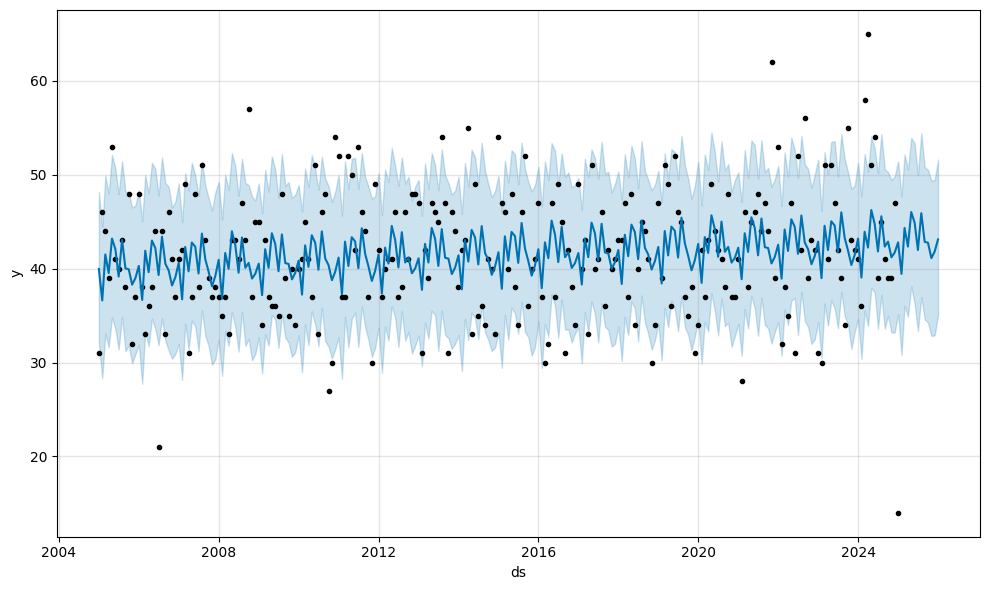

In [82]:
from prophet import Prophet

df9['Date_Of_Diagnosis'] = pd.to_datetime(df9['Date_Of_Diagnosis'], errors='coerce')
monthly_counts = df9.groupby(df9['Date_Of_Diagnosis'].dt.to_period('M')).size().reset_index(name='y')
monthly_counts['ds'] = monthly_counts['Date_Of_Diagnosis'].dt.to_timestamp()
monthly_counts = monthly_counts[['ds', 'y']].sort_values('ds')

prophet_model = Prophet()
prophet_model.fit(monthly_counts)

# 12 months
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
forecast = prophet_model.predict(future)

forecast_fig = prophet_model.plot(forecast)


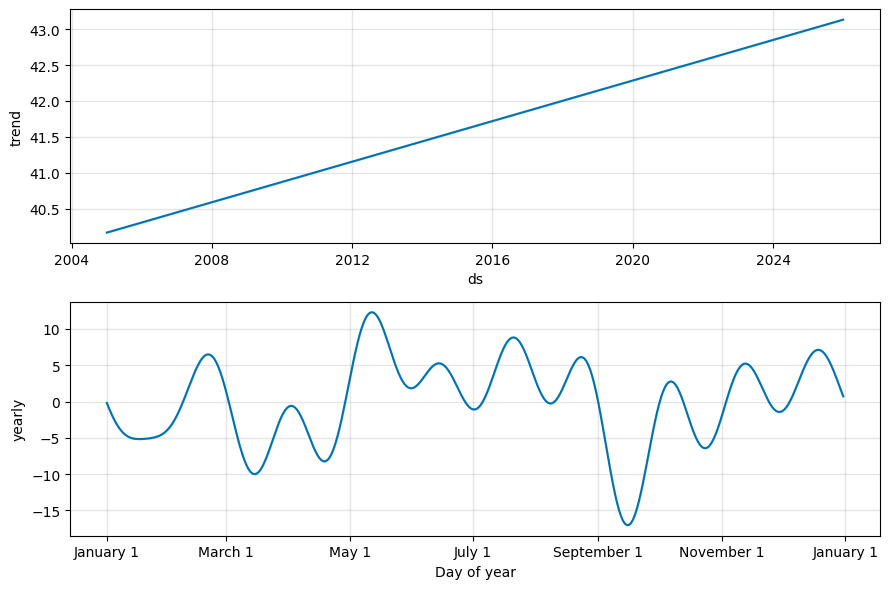

In [83]:
prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()

Kmeans Clustering

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

features = ['Age', 'CD4_Count', 'Viral_Load', 'Adherence_Percentage']
X = df9[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append((k, score))

best_k = max(silhouette_scores, key=lambda x: x[1])[0]

kmeans_final = KMeans(n_clusters=best_k, random_state=42)
df9['Cluster'] = kmeans_final.fit_predict(X_scaled)

best_k, df9[['Age', 'CD4_Count', 'Viral_Load', 'Adherence_Percentage', 'Cluster']].head()


(8,
    Age  CD4_Count  Viral_Load  Adherence_Percentage  Cluster
 0   53        415      447263                    85        5
 1   66        300      124546                    64        0
 2   43        669      306422                    76        1
 3   29        379      398170                    98        1
 4   57        838      136020                    54        2)

In [86]:
df9.head()

,Patient_ID,Age,Gender,Region,CD4_Count,Viral_Load,ART_Regimen,Adherence_Percentage,Follow_Up_Visits,Comorbidities,Transmission_Route,Marital_Status,Employment_Status,Education_Level,Date_Of_Diagnosis,Adherence_Bin,Treatment_Status,Cluster
0,P000001,53,Female,East,415,447263,Second-line,85,7,Diabetes,Mother-to-child,Married,Unemployed,Tertiary,2019-09-27,High,1,5
1,P000002,66,Male,Central,300,124546,Second-line,64,1,Hepatitis,Sexual,Divorced,Employed,Tertiary,2011-09-08,Medium,0,0
2,P000003,43,Male,South,669,306422,Third-line,76,8,Hepatitis,Sexual,Single,Unemployed,Secondary,2006-01-06,Medium,0,1
3,P000004,29,Male,East,379,398170,Second-line,98,6,Tuberculosis,Needle sharing,Single,Unemployed,Primary,2006-04-05,High,0,1
4,P000005,57,Male,East,838,136020,Second-line,54,5,Tuberculosis,Sexual,Divorced,Employed,Tertiary,2017-07-01,Low,0,2


In [87]:
# cluster distribution
fig = px.histogram(
    df9,
    x="Cluster",
    color="Cluster",
    title="Distribution of Patient Clusters",
    labels={"Cluster": "Cluster Group", "count": "Number of Patients"},
    nbins=len(df9['Cluster'].unique()),
    text_auto=True
)
fig.update_layout(bargap=0.2)
fig.show()


# **4. TB(Tuberculosis)**

# **4.1 Tuberculosis with Diabetes**

In [88]:
df_diabetes = pd.read_csv('2.10_TB_Diabetes.csv')

In [89]:
df_diabetes.head()

,State/Uts,"No of TB - Diabetes-TB patients with known DM status, of notified)-Public","Percentage of TB - Diabetes-TB patients with known DM status,of notified)-Public","No of TB - Diabetes-TB patients with known DM status, of notified)-Private","Percentage of TB - Diabetes-TB patients with known DM status, of notified)-Private","No of TB - Diabetes-TB patients with known DM status,of notified)-Total","Percentage of TB - Diabetes-TB patients with known DM status, of notified)-Total","No of TB - Diabetes-Patients diagnosed among tested,of those with known DM status)-Public","Percentage of TB - Diabetes- Patients diagnosed among tested,of those with known DM status)-Public","No of TB - Diabetes- Patients diagnosed among tested, of those with known DM status)-Private","Percentage of TB - Diabetes-Patients diagnosed among tested, of those with known DM status)-Private","No of TB - Diabetes-Patients diagnosed among tested, of those with known DM status)-Total","Percentage of TB - Diabetes- Patients diagnosed among tested, of those with known DM status)-Total","No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Public","Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Public","No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Private","Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Private","No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)0Total","Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment,of TB-DM)0Total"
0,Andaman & Nicobar Islands,518,95.2,3,75.0,521,95.1,97,18.7,1,33.3,98,18.8,69,71.1,1,100.00,70,71.4
1,Andhra Pradesh,65235,98.7,26883,99.6,92118,98.9,8816,13.5,2940,10.9,11756,12.8,6282,71.3,1671,56.80,7953,67.7
2,Arunachal Pradesh,2378,79.0,3,50.0,2381,79.0,59,2.5,0,0.0,59,2.5,28,47.5,449,53.25,28,47.5
3,Assam,34011,81.0,4929,83.2,38940,81.2,2554,7.5,499,10.1,3053,7.8,1003,39.3,179,35.90,1182,38.7
4,Bihar,53768,66.1,74114,87.7,127882,77.1,3062,5.7,3801,5.1,6863,5.4,1489,48.6,811,21.30,2300,33.5


In [90]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 19 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   State/Uts                                                                                              37 non-null     object 
 1   No of TB - Diabetes-TB patients with known DM status, of notified)-Public                              37 non-null     int64  
 2   Percentage  of TB - Diabetes-TB patients with known DM status,of notified)-Public                      37 non-null     float64
 3   No of TB - Diabetes-TB patients with known DM status, of notified)-Private                             37 non-null     int64  
 4   Percentage  of TB - Diabetes-TB patients with known DM status, of notified)-Private                 

In [91]:
df_diabetes.isnull().sum()

,0
State/Uts,0
"No of TB - Diabetes-TB patients with known DM status, of notified)-Public",0
"Percentage of TB - Diabetes-TB patients with known DM status,of notified)-Public",0
"No of TB - Diabetes-TB patients with known DM status, of notified)-Private",0
"Percentage of TB - Diabetes-TB patients with known DM status, of notified)-Private",0
"No of TB - Diabetes-TB patients with known DM status,of notified)-Total",0
"Percentage of TB - Diabetes-TB patients with known DM status, of notified)-Total",0
"No of TB - Diabetes-Patients diagnosed among tested,of those with known DM status)-Public",0
"Percentage of TB - Diabetes- Patients diagnosed among tested,of those with known DM status)-Public",0
"No of TB - Diabetes- Patients diagnosed among tested, of those with known DM status)-Private",0


In [92]:
new_column_names = {
    'State/Uts': 'State',
    'No of TB - Diabetes-TB patients with known DM status, of notified)-Public': 'TB_DM_Known_Pub',
    'Percentage  of TB - Diabetes-TB patients with known DM status,of notified)-Public': 'TB_DM_Known_Pub_%',
    'No of TB - Diabetes-TB patients with known DM status, of notified)-Private': 'TB_DM_Known_Pvt',
    'Percentage  of TB - Diabetes-TB patients with known DM status, of notified)-Private': 'TB_DM_Known_Pvt_%',
    'No of TB - Diabetes-TB patients with known DM status,of notified)-Total': 'TB_DM_Known_Total',
    'Percentage of TB - Diabetes-TB patients with known DM status,  of notified)-Total': 'TB_DM_Known_Total_%',
    'No of TB - Diabetes-Patients diagnosed among tested,of those with known DM status)-Public': 'TB_DM_Diag_Pub',
    'Percentage of TB - Diabetes- Patients diagnosed among tested,of those with known DM status)-Public': 'TB_DM_Diag_Pub_%',
    'No of TB - Diabetes- Patients diagnosed among tested, of those with known DM status)-Private': 'TB_DM_Diag_Pvt',
    'Percentage  of TB - Diabetes-Patients diagnosed among tested,  of those with known DM status)-Private': 'TB_DM_Diag_Pvt_%',
    'No of TB - Diabetes-Patients diagnosed among tested, of those with known DM status)-Total': 'TB_DM_Diag_Total',
    'Percentage  of TB - Diabetes-  Patients diagnosed among tested, of those with known DM status)-Total': 'TB_DM_Diag_Total_%',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Public': 'TB_DM_Treat_Pub',
    'Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Public': 'TB_DM_Treat_Pub_%',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Private': 'TB_DM_Treat_Pvt',
    'Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Private': 'TB_DM_Treat_Pvt_%',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)0Total': 'TB_DM_Treat_Total',
    'Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment,of TB-DM)0Total': 'TB_DM_Treat_Total_%'
}

# Renaming
df_diabetes.rename(columns=new_column_names, inplace=True)

In [93]:
df_diabetes.columns

Index(['State', 'TB_DM_Known_Pub', 'TB_DM_Known_Pub_%', 'TB_DM_Known_Pvt',
       'TB_DM_Known_Pvt_%', 'TB_DM_Known_Total', 'TB_DM_Known_Total_%',
       'TB_DM_Diag_Pub', 'TB_DM_Diag_Pub_%', 'TB_DM_Diag_Pvt',
       'TB_DM_Diag_Pvt_%', 'TB_DM_Diag_Total', 'TB_DM_Diag_Total_%',
       'TB_DM_Treat_Pub', 'TB_DM_Treat_Pub_%', 'TB_DM_Treat_Pvt',
       'TB_DM_Treat_Pvt_%', 'TB_DM_Treat_Total', 'TB_DM_Treat_Total_%'],
      dtype='object')

In [94]:
df_diabetes.columns = df_diabetes.columns.str.strip()

df_diabetes = df_diabetes[df_diabetes["State"] != "India"]

print(df_diabetes.columns)

numerical_features = df_diabetes.select_dtypes(include=['number']).drop(columns=[
    'TB_DM_Known_Pub_%', 'TB_DM_Known_Pvt_%', 'TB_DM_Known_Total_%',
    'TB_DM_Diag_Pub_%', 'TB_DM_Diag_Pvt_%', 'TB_DM_Diag_Total_%',
    'TB_DM_Treat_Pub_%', 'TB_DM_Treat_Pvt_%', 'TB_DM_Treat_Total_%'
], errors='ignore').columns

df_diabetes["Total_Cases"] = df_diabetes[numerical_features].sum(axis=1)

fig = px.sunburst(df_diabetes,
                  path=["State"],
                  values="Total_Cases",
                  color="Total_Cases",
                  color_continuous_scale="Viridis",
                  title="State-wise TB-Diabetes Cases in India (Excluding India)")

fig.show()

Index(['State', 'TB_DM_Known_Pub', 'TB_DM_Known_Pub_%', 'TB_DM_Known_Pvt',
       'TB_DM_Known_Pvt_%', 'TB_DM_Known_Total', 'TB_DM_Known_Total_%',
       'TB_DM_Diag_Pub', 'TB_DM_Diag_Pub_%', 'TB_DM_Diag_Pvt',
       'TB_DM_Diag_Pvt_%', 'TB_DM_Diag_Total', 'TB_DM_Diag_Total_%',
       'TB_DM_Treat_Pub', 'TB_DM_Treat_Pub_%', 'TB_DM_Treat_Pvt',
       'TB_DM_Treat_Pvt_%', 'TB_DM_Treat_Total', 'TB_DM_Treat_Total_%'],
      dtype='object')


/tmp/ipython-input-94-1533914613.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
df_diabetes.head(10)

,State,TB_DM_Known_Pub,TB_DM_Known_Pub_%,TB_DM_Known_Pvt,TB_DM_Known_Pvt_%,TB_DM_Known_Total,TB_DM_Known_Total_%,TB_DM_Diag_Pub,TB_DM_Diag_Pub_%,TB_DM_Diag_Pvt,TB_DM_Diag_Pvt_%,TB_DM_Diag_Total,TB_DM_Diag_Total_%,TB_DM_Treat_Pub,TB_DM_Treat_Pub_%,TB_DM_Treat_Pvt,TB_DM_Treat_Pvt_%,TB_DM_Treat_Total,TB_DM_Treat_Total_%,Total_Cases
0,Andaman & Nicobar Islands,518,95.2,3,75.0,521,95.1,97,18.7,1,33.3,98,18.8,69,71.1,1,100.00,70,71.4,1378
1,Andhra Pradesh,65235,98.7,26883,99.6,92118,98.9,8816,13.5,2940,10.9,11756,12.8,6282,71.3,1671,56.80,7953,67.7,223654
2,Arunachal Pradesh,2378,79.0,3,50.0,2381,79.0,59,2.5,0,0.0,59,2.5,28,47.5,449,53.25,28,47.5,5385
3,Assam,34011,81.0,4929,83.2,38940,81.2,2554,7.5,499,10.1,3053,7.8,1003,39.3,179,35.90,1182,38.7,86350
4,Bihar,53768,66.1,74114,87.7,127882,77.1,3062,5.7,3801,5.1,6863,5.4,1489,48.6,811,21.30,2300,33.5,274090
5,Chandigarh,3531,94.9,47,73.4,3578,94.6,316,8.9,5,10.6,321,9.0,248,78.5,5,100.00,253,78.8,8304
6,Chhattisgarh,26987,91.6,8243,88.8,35230,91.0,2473,9.2,639,7.8,3112,8.8,1184,47.9,155,24.30,1339,43.0,79362
7,Dadra and Nagar Haveli and Daman and Diu,838,99.2,76,100.0,914,99.2,56,6.7,3,3.9,59,6.5,46,82.1,2,66.70,48,81.4,2042
8,Delhi,65700,84.2,5628,55.0,71328,80.8,5323,8.1,621,11.0,5944,8.3,2661,50.0,168,27.10,2829,47.6,160202
9,Goa,1659,98.9,288,72.7,1947,93.9,332,20.0,45,15.6,377,19.4,300,90.4,25,55.60,325,86.2,5298


In [96]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


column_to_visualize = "TB_DM_Known_Total"

df_sorted = df_diabetes.copy()

df_sorted = df_sorted.sort_values(by=column_to_visualize, ascending=True)

colors = px.colors.sequential.Rainbow  # Try 'Viridis', 'Plasma', 'Turbo' etc.

fig = go.Figure()

for i, (state, value) in enumerate(zip(df_sorted["State"], df_sorted[column_to_visualize])):
    fig.add_trace(go.Bar(
        x=[state],
        y=[value],
        name=state,
        marker_color=colors[i % len(colors)]
    ))

fig.update_layout(
    title="TB-Diabetes Cases Distribution Across States",
    xaxis=dict(title="States", tickangle=45),
    yaxis=dict(title=column_to_visualize),
    showlegend=False,
    template="plotly_dark",
)

fig.show()

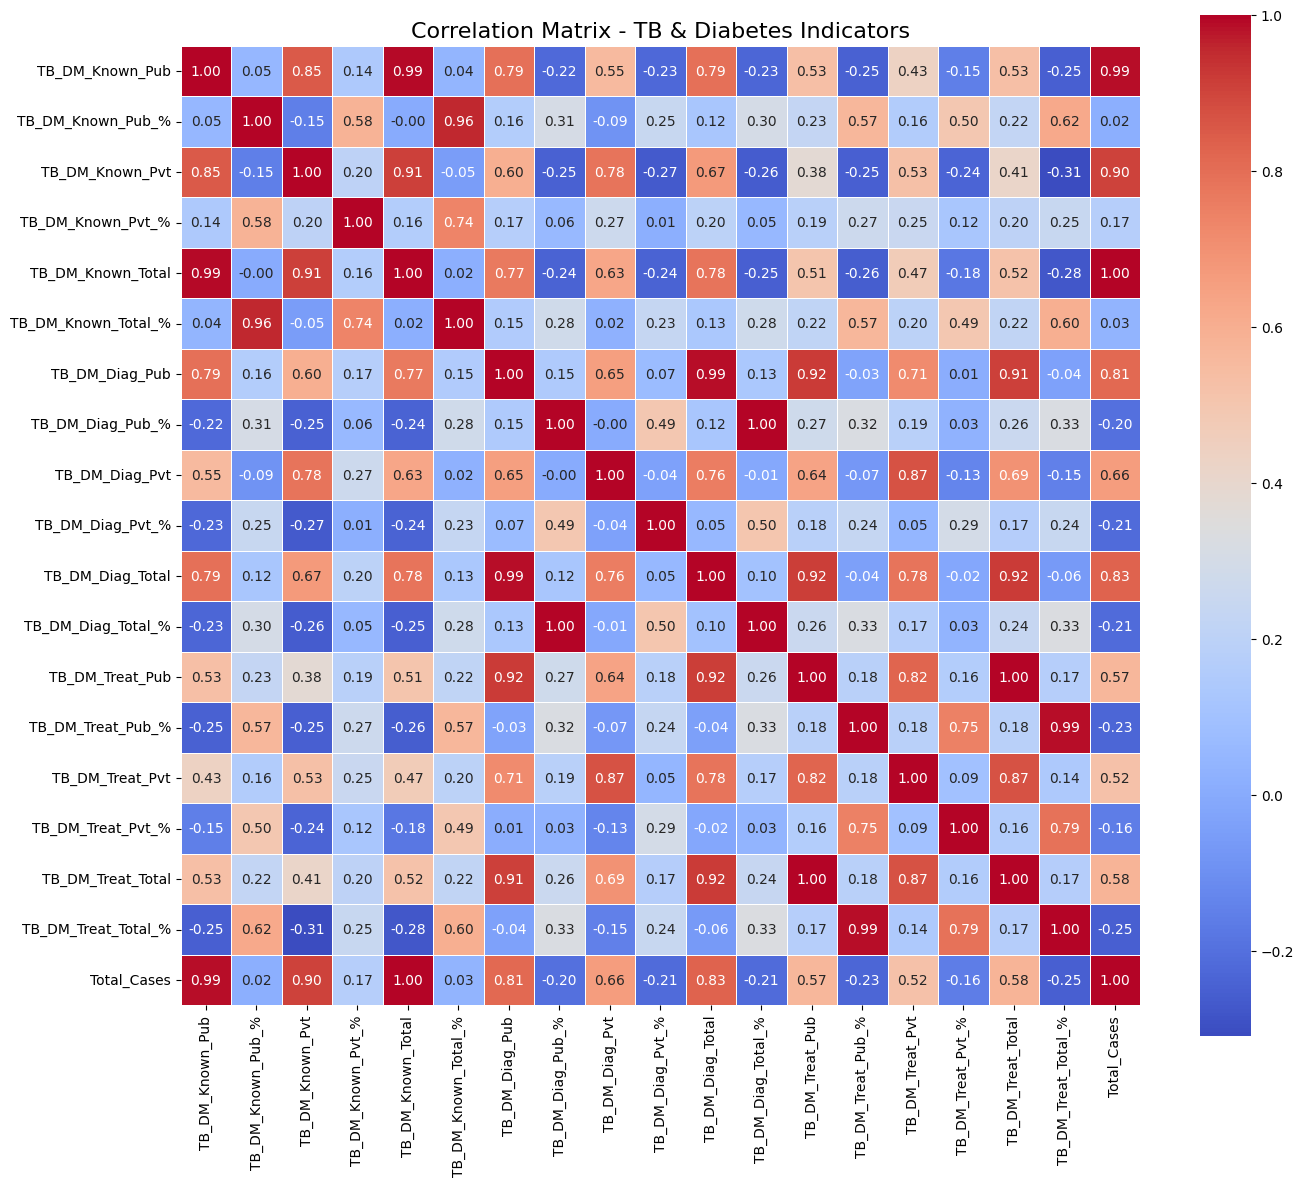

In [97]:
new_column_names = {
    'State/Uts': 'State',
    'No of TB - Diabetes-TB patients with known DM status, of notified)-Public': 'TB_DM_Known_Pub',
    'Percentage  of TB - Diabetes-TB patients with known DM status,of notified)-Public': 'TB_DM_Known_Pub_%',
    'No of TB - Diabetes-TB patients with known DM status, of notified)-Private': 'TB_DM_Known_Pvt',
    'Percentage  of TB - Diabetes-TB patients with known DM status, of notified)-Private': 'TB_DM_Known_Pvt_%',
    'No of TB - Diabetes-TB patients with known DM status,of notified)-Total': 'TB_DM_Known_Total',
    'Percentage of TB - Diabetes-TB patients with known DM status,  of notified)-Total': 'TB_DM_Known_Total_%',
    'No of TB - Diabetes-Patients diagnosed among tested,of those with known DM status)-Public': 'TB_DM_Diag_Pub',
    'Percentage of TB - Diabetes- Patients diagnosed among tested,of those with known DM status)-Public': 'TB_DM_Diag_Pub_%',
    'No of TB - Diabetes- Patients diagnosed among tested, of those with known DM status)-Private': 'TB_DM_Diag_Pvt',
    'Percentage  of TB - Diabetes-Patients diagnosed among tested,  of those with known DM status)-Private': 'TB_DM_Diag_Pvt_%',
    'No of TB - Diabetes-Patients diagnosed among tested, of those with known DM status)-Total': 'TB_DM_Diag_Total',
    'Percentage  of TB - Diabetes-  Patients diagnosed among tested, of those with known DM status)-Total': 'TB_DM_Diag_Total_%',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Public': 'TB_DM_Treat_Pub',
    'Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Public': 'TB_DM_Treat_Pub_%',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Private': 'TB_DM_Treat_Pvt',
    'Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)-Private': 'TB_DM_Treat_Pvt_%',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)0Total': 'TB_DM_Treat_Total',
    'Percentage of TB - Diabetes- patients initiated on Anti-diabetic treatment,of TB-DM)0Total': 'TB_DM_Treat_Total_%'
}

df_diabetes.rename(columns=new_column_names, inplace=True)

df_numeric = df_diabetes.select_dtypes(include='number')

corr = df_numeric.corr()

plt.figure(figsize=(14, 12))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

plt.title("Correlation Matrix - TB & Diabetes Indicators", fontsize=16)

plt.tight_layout()
plt.show()

In [98]:
# Rename columns
df_diabetes.rename(columns={
    'State/Uts': 'State',
    'No of TB - Diabetes-TB patients with known DM status,of notified)-Total': 'TB_DM_Known_Total',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)0Total': 'TB_DM_Treat_Total'
}, inplace=True)

# Ensure numeric values
df_diabetes["TB_DM_Known_Total"] = pd.to_numeric(df_diabetes["TB_DM_Known_Total"], errors="coerce").fillna(0)
df_diabetes["TB_DM_Treat_Total"] = pd.to_numeric(df_diabetes["TB_DM_Treat_Total"], errors="coerce").fillna(0)

# Calculate linkage percentage
df_diabetes["Treatment_Linkage_Percent"] = df_diabetes.apply(
    lambda row: (row["TB_DM_Treat_Total"] / row["TB_DM_Known_Total"] * 100) if row["TB_DM_Known_Total"] > 0 else 0,
    axis=1
)

# Scatter plot
fig = px.scatter(
    df_diabetes,
    x="TB_DM_Known_Total",
    y="TB_DM_Treat_Total",
    color="Treatment_Linkage_Percent",
    size="Treatment_Linkage_Percent",
    hover_name="State",
    color_continuous_scale="Viridis",
    title="TB-Diabetes: Known DM Status vs. Initiated Anti-diabetic Treatment",
    labels={
        "TB_DM_Known_Total": "TB Patients with Known DM Status (Total)",
        "TB_DM_Treat_Total": "TB-DM Patients Initiated on Anti-diabetic Treatment (Total)",
        "Treatment_Linkage_Percent": "% Treated"
    }
)

fig.update_layout(template="plotly_dark")
fig.show()

In [99]:
# Rename key columns
df_diabetes.rename(columns={
    'State/Uts': 'State',
    'No of TB - Diabetes-TB patients with known DM status,of notified)-Total': 'TB_DM_Known_Total',
    'No of TB - Diabetes-Patients diagnosed among tested, of those with known DM status)-Total': 'TB_DM_Diag_Total',
    'No of TB - Diabetes- patients initiated on Anti-diabetic treatment, of TB-DM)0Total': 'TB_DM_Treat_Total'
}, inplace=True)

# Convert relevant columns to numeric
for col in ['TB_DM_Known_Total', 'TB_DM_Diag_Total', 'TB_DM_Treat_Total']:
    df_diabetes[col] = pd.to_numeric(df_diabetes[col], errors='coerce').fillna(0)

# Aggregate totals
total_known = df_diabetes['TB_DM_Known_Total'].sum()
total_diagnosed = df_diabetes['TB_DM_Diag_Total'].sum()
total_treated = df_diabetes['TB_DM_Treat_Total'].sum()

# Prepare funnel data (reversed order)
funnel_data = pd.DataFrame({
    "Stage": [
        "Initiated Anti-diabetic Treatment",
        "Diagnosed Among Known DM",
        "Known DM Status (Total)"
    ],
    "Patients": [total_treated, total_diagnosed, total_known],
    "Color": ["#00CC96", "#EF553B", "#636EFA"]
})

funnel_fig = px.funnel(
    funnel_data,
    x="Patients",
    y="Stage",
    color="Stage",
    color_discrete_map={
        "Known DM Status (Total)": "#636EFA",
        "Diagnosed Among Known DM": "#EF553B",
        "Initiated Anti-diabetic Treatment": "#00CC96"
    },
    title="TB-Diabetes Care Cascade Funnel (Reversed)",
    labels={"Patients": "Number of Patients", "Stage": "Care Stage"}
)

funnel_fig.update_layout(template="plotly_dark")
funnel_fig.show()

# **4.2 Tuberculosis with Alcohol**

In [100]:
df_alcohol= pd.read_csv('2.12_TB_Alcohol.csv')

In [101]:
df_alcohol.head()

,State/Uts,"No of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Public","% of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Public","No of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Private","% of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Private","No of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Total","% of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Total","No of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Public","Percentage of TB - Alcohol-Alcohol users identified amongst screened,of those with known alcohol usage status)-Public","No of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Private","Percentage of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Private","No of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Total","Percentage of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Total","No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Public","Percentage of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Public","No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Private","Percentage of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Private","No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Total","Percentage of No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Total"
0,Andaman & Nicobar Islands,490,90.1,3,75.0,493,90.0,90,18.4,0,0.0,90,18.3,26,28.9,NaN,NaN,26.0,28.9
1,Andhra Pradesh,63257,95.7,26303,97.5,89560,96.2,8187,12.9,1208,4.6,9395,10.5,1901,23.2,265.0,21.9,2166.0,23.1
2,Arunachal Pradesh,2240,74.4,3,50.0,2243,74.4,245,10.9,0,0.0,245,10.9,140,57.1,NaN,NaN,140.0,57.1
3,Assam,29582,70.4,4366,73.7,33948,70.8,5161,17.4,179,4.1,5340,15.7,1244,24.1,71.0,39.7,1315.0,24.6
4,Bihar,44246,54.4,35745,42.3,79991,48.2,781,1.8,254,0.7,1035,1.3,254,32.5,9.0,3.5,263.0,25.4


In [102]:
new_column_names = {
    'State/Uts': 'State_UTs',
    ' No of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Public': 'TB_Alcohol_Pub_Count',
    '% of  TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Public': 'TB_Alcohol_Pub_Percent',
    'No of  TB - Alcohol-TB patients with known Alcohol usage status,  of notified)-Private': 'TB_Alcohol_Priv_Count',
    '% of  TB - Alcohol-TB patients with known Alcohol usage status,  of notified)-Private': 'TB_Alcohol_Priv_Percent',
    ' No of TB - Alcohol-TB patients with known Alcohol usage status,  of notified)-Total': 'TB_Alcohol_Total_Count',
    '% of TB - Alcohol-TB patients with known Alcohol usage status, of notified)-Total': 'TB_Alcohol_Total_Percent',
    'No of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Public': 'Alcohol_Users_Pub_Count',
    'Percentage  of TB - Alcohol-Alcohol users identified amongst screened,of those with known alcohol usage status)-Public': 'Alcohol_Users_Pub_Percent',
    'No of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Private': 'Alcohol_Users_Priv_Count',
    'Percentage  of TB - Alcohol-Alcohol users identified amongst screened, of those with known alcohol usage status)-Private': 'Alcohol_Users_Priv_Percent',
    'No of TB - Alcohol-Alcohol users identified amongst screened,  of those with known alcohol usage status)-Total': 'Alcohol_Users_Total_Count',
    'Percentage  of TB - Alcohol-Alcohol users identified amongst screened,  of those with known alcohol usage status)-Total': 'Alcohol_Users_Total_Percent',
    'No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Public': 'Deaddiction_Linked_Pub_Count',
    'Percentage  of TB - Alcohol-Alcohol users linked with Deaddiction centres,  of alcohol users)-Public': 'Deaddiction_Linked_Pub_Percent',
    'No of TB - Alcohol-Alcohol users linked with Deaddiction centres,  of alcohol users)-Private': 'Deaddiction_Linked_Priv_Count',
    'Percentage  of TB - Alcohol-Alcohol users linked with Deaddiction centres,  of alcohol users)-Private': 'Deaddiction_Linked_Priv_Percent',
    'No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Total': 'Deaddiction_Linked_Total_Count',
    'Percentage  of No of TB - Alcohol-Alcohol users linked with Deaddiction centres, of alcohol users)-Total': 'Deaddiction_Linked_Total_Percent'
}

# Rename the columns
df_alcohol.rename(columns=new_column_names, inplace=True)

In [103]:
df_alcohol.columns = df_alcohol.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True)

print(df_alcohol.columns.tolist())

for col in df_alcohol.columns:
    if "State" in col:
        df_alcohol = df_alcohol.rename(columns={col: "State"})
        break

df_alcohol = df_alcohol[df_alcohol["State"] != "India"]

percentage_columns = [col for col in df_alcohol.columns if "Percentage" in col or "%" in col]

numerical_features = df_alcohol.select_dtypes(include=['number']).drop(columns=percentage_columns, errors='ignore').columns

df_alcohol[numerical_features] = df_alcohol[numerical_features].apply(pd.to_numeric, errors='coerce').fillna(0)

df_alcohol["Total_Cases"] = df_alcohol[numerical_features].sum(axis=1)

fig = px.sunburst(df_alcohol,
                  path=["State"],
                  values="Total_Cases",
                  color="Total_Cases",
                  color_continuous_scale="Magma",
                  title="State-wise TB-Alcohol Related Cases in India")

fig.show()

['State_UTs', 'TB_Alcohol_Pub_Count', 'TB_Alcohol_Pub_Percent', 'TB_Alcohol_Priv_Count', 'TB_Alcohol_Priv_Percent', 'TB_Alcohol_Total_Count', 'TB_Alcohol_Total_Percent', 'Alcohol_Users_Pub_Count', 'Alcohol_Users_Pub_Percent', 'Alcohol_Users_Priv_Count', 'Alcohol_Users_Priv_Percent', 'Alcohol_Users_Total_Count', 'Alcohol_Users_Total_Percent', 'Deaddiction_Linked_Pub_Count', 'Deaddiction_Linked_Pub_Percent', 'Deaddiction_Linked_Priv_Count', 'Deaddiction_Linked_Priv_Percent', 'Deaddiction_Linked_Total_Count', 'Deaddiction_Linked_Total_Percent']


In [104]:
column_to_visualize = "TB_Alcohol_Total_Count"

df_alcohol = df_alcohol.sort_values(by=column_to_visualize, ascending=True)

colors = px.colors.sequential.Rainbow

fig = go.Figure()

for i, (state, value) in enumerate(zip(df_alcohol["State"], df_alcohol[column_to_visualize])):
    fig.add_trace(go.Bar(
        x=[state],
        y=[value],
        name=state,
        marker_color=colors[i % len(colors)]
    ))

# Update layout for better visuals
fig.update_layout(
    title="Alcohol-TB Cases Distribution Across States",
    xaxis=dict(title="States", tickangle=45),
    yaxis=dict(title=column_to_visualize.replace("_", " ")),
    showlegend=False,
    template="plotly_dark"  # Use 'plotly_white' for a lighter theme
)

fig.show()


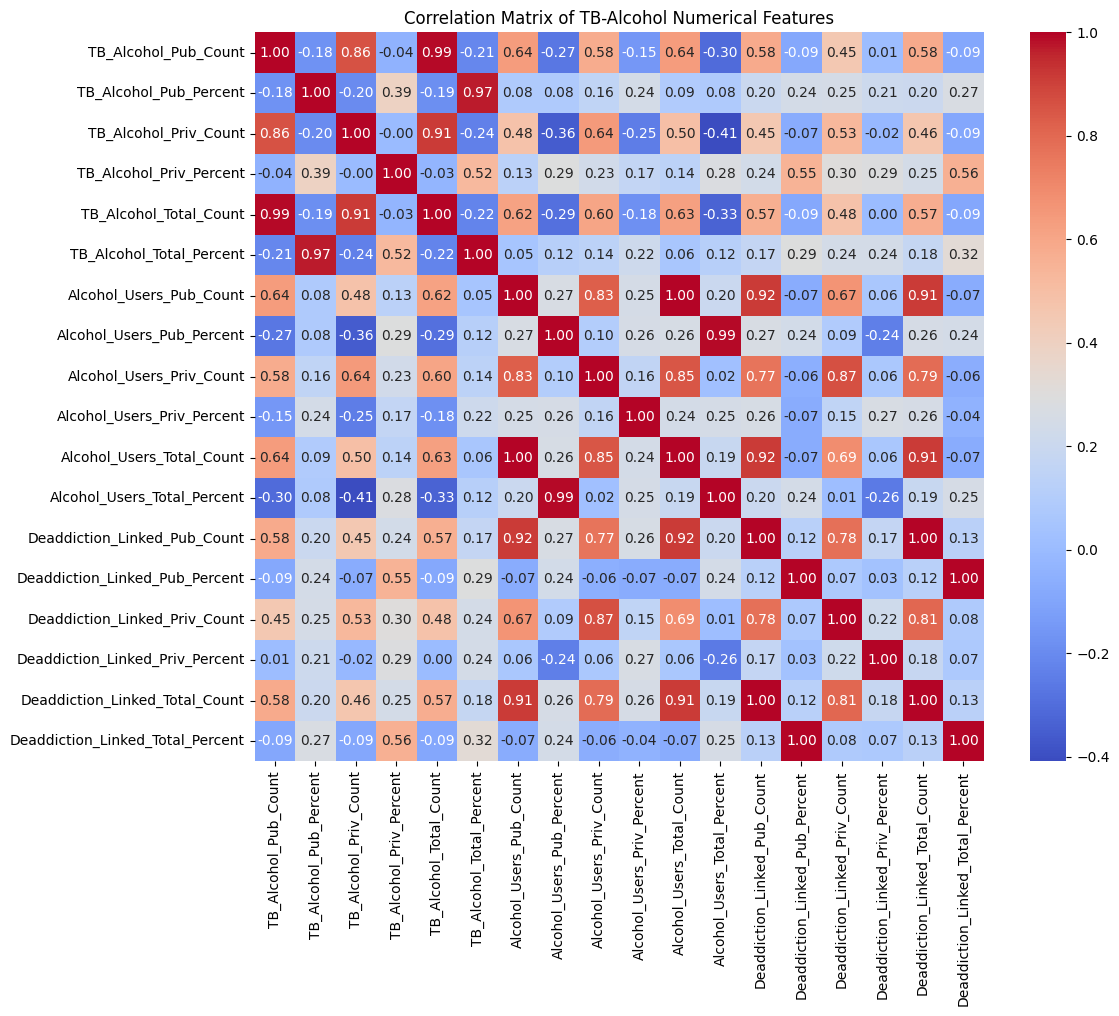

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 10))

# Create correlation heatmap
sns.heatmap(df_alcohol[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)

# Title and show
plt.title("Correlation Matrix of TB-Alcohol Numerical Features")
plt.tight_layout()
plt.show()

In [106]:

identified_col = "Alcohol_Users_Total_Count"
linked_col = "Deaddiction_Linked_Total_Count"

df_alcohol[identified_col] = pd.to_numeric(df_alcohol[identified_col], errors='coerce').fillna(0)
df_alcohol[linked_col] = pd.to_numeric(df_alcohol[linked_col], errors='coerce').fillna(0)

df_alcohol["Linkage_Percent"] = df_alcohol.apply(
    lambda row: (row[linked_col] / row[identified_col] * 100) if row[identified_col] > 0 else 0,
    axis=1
)

fig = px.scatter(df_alcohol,
                 x=identified_col,
                 y=linked_col,
                 color="Linkage_Percent",
                 size="Linkage_Percent",
                 hover_name="State",
                 color_continuous_scale="Viridis",
                 title="Alcohol Users Identified vs Linked to Deaddiction Centers",
                 labels={
                     identified_col: "Alcohol Users Identified (Total)",
                     linked_col: "Linked to Deaddiction Centers (Total)",
                     "Linkage_Percent": "% Linked"
                 })

fig.update_layout(template="plotly_dark")  # Optional theme
fig.show()

In [107]:
public_col = "Deaddiction_Linked_Pub_Count"
private_col = "Deaddiction_Linked_Priv_Count"
total_col = "Deaddiction_Linked_Total_Count"

df_alcohol_sorted = df_alcohol.sort_values(by=total_col, ascending=False)

fig = go.Figure(data=[
    go.Bar(name="Public", x=df_alcohol_sorted["State"], y=df_alcohol_sorted[public_col], marker_color="teal"),
    go.Bar(name="Private", x=df_alcohol_sorted["State"], y=df_alcohol_sorted[private_col], marker_color="orange"),
    go.Bar(name="Total", x=df_alcohol_sorted["State"], y=df_alcohol_sorted[total_col], marker_color="purple")
])

fig.update_layout(
    title="Public vs Private vs Total Deaddiction Linkages by State",
    xaxis_title="State",
    yaxis_title="Number of Alcohol-TB Patients Linked",
    barmode='group',
    xaxis_tickangle=45,
    template="plotly_dark",
    width=1000,
    height=600
)

fig.show()

In [108]:
known_status_total = df_alcohol["TB_Alcohol_Total_Count"].sum()
identified_total = df_alcohol["Alcohol_Users_Total_Count"].sum()
linked_total = df_alcohol["Deaddiction_Linked_Total_Count"].sum()

fig = go.Figure(go.Funnel(
    y=[
        "Known Alcohol Usage Status",
        "Alcohol Users Identified",
        "Linked to Deaddiction Centers"
    ],
    x=[known_status_total, identified_total, linked_total],
    textinfo="value+percent previous+percent total",
    marker={"color": ["#1f77b4", "#ff7f0e", "#2ca02c"]}
))

fig.update_layout(
    title="TB-Alcohol Screening & Deaddiction Funnel (All India)",
    template="plotly_dark",
    width=700,
    height=500
)

fig.show()

# **4.3 Tuberculosis with Tobacco**

In [109]:
df_tobacco = pd.read_csv('2.11_TB_Tobacco.csv')

In [110]:
df_tobacco.head()

,State/Uts,"No of Tobacco-TB patients with known Tobacco usage status, of notified)-Public","% of Tobacco-TB patients with known Tobacco usage status, of notified)-Public","No of Tobacco-TB patients with known Tobacco usage status,of notified)-Private","% of Tobacco-TB patients with known Tobacco usage status, of notified)-Private","No of Tobacco-TB patients with known Tobacco usage status, of notified)-Total","% of Tobacco-TB patients with known Tobacco usage status, of notified)-Total","No of Tobacco users identified amongst screened, of those with known tobacco usage status)-Public","Percentage of Tobacco users identified amongst screened, of those with known tobacco usage status)-Public","No of Tobacco users identified amongst screened,of those with known tobacco usage status)-Private","Percentage of Tobacco users identified amongst screened, of those with known tobacco usage status)-Private","No of Tobacco users identified amongst screened,of those with known tobacco usage status)-Total","Percentage of Tobacco users identified amongst screened, of those with known tobacco usage status)-Total","No of Tobacco users linked with Tobacco cessation centres, of tobacco users)-Public","Percentage of Tobacco users linked with Tobacco cessation centres, of tobacco users)-Public","No of Tobacco users linked with Tobacco cessation centres,of tobacco users)-Private","Percentage of Tobacco users linked with Tobacco cessation centres, n (% of tobacco users)-Private","No of Tobacco users linked with Tobacco cessation centres, of tobacco users)-Total","Percentage of Tobacco users linked with Tobacco cessation centres, of tobacco users)-Total"
0,Andaman & Nicobar Islands,495,91.0,3,75.0,498,90.9,89,18.0,0,0.0,89,17.9,30,33.7,122,36.9,30,33.7
1,Andhra Pradesh,63627,96.2,26477,98.1,90104,96.8,9786,15.4,1409,5.3,11195,12.4,2456,25.1,326,23.1,2782,24.9
2,Arunachal Pradesh,2256,75.0,3,50.0,2259,74.9,303,13.4,0,0.0,303,13.4,171,56.4,122,36.9,171,56.4
3,Assam,30134,71.7,4074,68.8,34208,71.4,7929,26.3,325,8.0,8254,24.1,1497,18.9,93,28.6,1590,19.3
4,Bihar,44248,54.4,36165,42.8,80413,48.5,4139,9.4,1152,3.2,5291,6.6,917,22.2,41,3.6,958,18.1


In [111]:
df_tobacco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 19 columns):
 #   Column                                                                                                       Non-Null Count  Dtype  
---  ------                                                                                                       --------------  -----  
 0   State/Uts                                                                                                    37 non-null     object 
 1   No of Tobacco-TB patients with known Tobacco usage status, of notified)-Public                               37 non-null     int64  
 2   % of Tobacco-TB patients with known Tobacco usage status, of notified)-Public                                37 non-null     float64
 3   No of Tobacco-TB patients with known Tobacco usage status,of notified)-Private                               37 non-null     int64  
 4   % of Tobacco-TB patients with known Tobacco usage status,  of no

In [112]:
df_tobacco.columns = df_tobacco.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True)

for col in df_tobacco.columns:
    if "State" in col:
        df_tobacco = df_tobacco.rename(columns={col: "State"})
        break

df_tobacco = df_tobacco[df_tobacco["State"] != "India"]

percentage_columns = [col for col in df_tobacco.columns if "Percentage" in col or "%" in col or "Pct" in col]

numerical_features = df_tobacco.select_dtypes(include=['number']).drop(columns=percentage_columns, errors='ignore').columns

df_tobacco[numerical_features] = df_tobacco[numerical_features].apply(pd.to_numeric, errors='coerce').fillna(0)

df_tobacco["Total_Cases"] = df_tobacco[numerical_features].sum(axis=1)

fig = px.sunburst(df_tobacco,
                  path=["State"],
                  values="Total_Cases",
                  color="Total_Cases",
                  color_continuous_scale="IceFire",
                  title="State-wise TB-Tobacco Related Cases in India")

fig.show()

In [113]:
df_tobacco.columns = df_tobacco.columns.str.strip().str.replace('[^A-Za-z0-9_]+', '_', regex=True)

for col in df_tobacco.columns:
    if "State" in col:
        df_tobacco = df_tobacco.rename(columns={col: "State"})
        break

df_tobacco = df_tobacco[df_tobacco["State"] != "India"]

percentage_columns = [col for col in df_tobacco.columns if "Percentage" in col or "%" in col or "Pct" in col]

numerical_features = df_tobacco.select_dtypes(include=['number']).drop(columns=percentage_columns, errors='ignore').columns
df_tobacco[numerical_features] = df_tobacco[numerical_features].apply(pd.to_numeric, errors='coerce').fillna(0)

df_tobacco["Total_Cases"] = df_tobacco[numerical_features].sum(axis=1)

column_to_visualize = "Total_Cases"

df_tobacco = df_tobacco.sort_values(by=column_to_visualize, ascending=True)

colors = px.colors.sequential.Rainbow

fig = go.Figure()

for i, (state, value) in enumerate(zip(df_tobacco["State"], df_tobacco[column_to_visualize])):
    fig.add_trace(go.Bar(
        x=[state],
        y=[value],
        name=state,
        marker_color=colors[i % len(colors)]
    ))

fig.update_layout(
    title="TB-Tobacco Cases Distribution Across States",
    xaxis=dict(title="States", tickangle=45),
    yaxis=dict(title=column_to_visualize.replace("_", " ")),
    showlegend=False,
    template="plotly_dark"
)

fig.show()

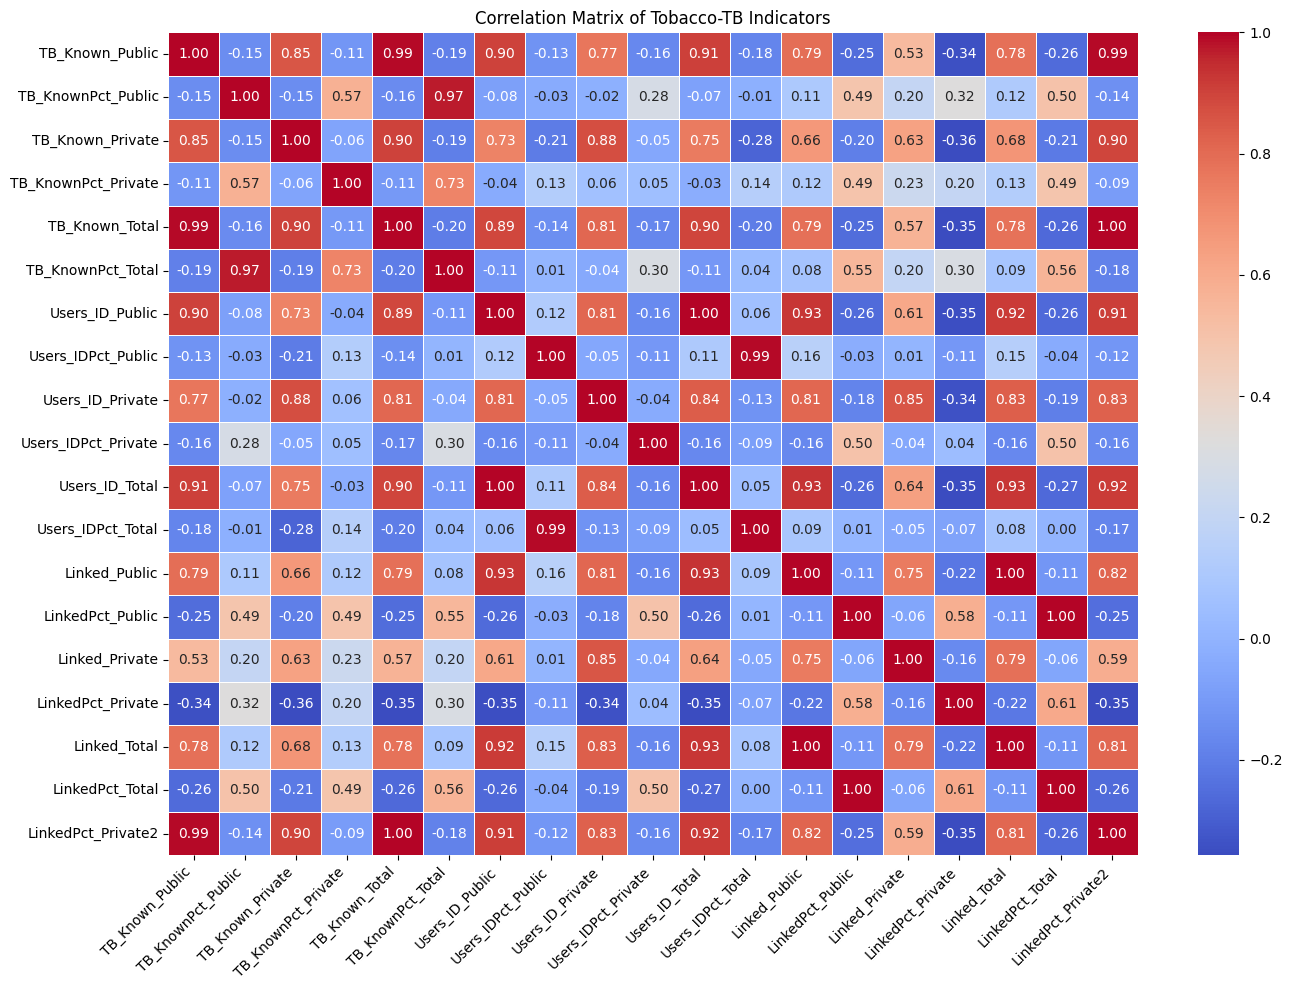

In [114]:
df_tobacco.columns = [
    'State',
    'TB_Known_Public',
    'TB_KnownPct_Public',
    'TB_Known_Private',
    'TB_KnownPct_Private',
    'TB_Known_Total',
    'TB_KnownPct_Total',
    'Users_ID_Public',
    'Users_IDPct_Public',
    'Users_ID_Private',
    'Users_IDPct_Private',
    'Users_ID_Total',
    'Users_IDPct_Total',
    'Linked_Public',
    'LinkedPct_Public',
    'Linked_Private',
    'LinkedPct_Private',
    'Linked_Total',
    'LinkedPct_Total',
    'LinkedPct_Private2'
]

df_tobacco_clean = df_tobacco.drop(columns=['State'])

df_tobacco_clean = df_tobacco_clean.apply(pd.to_numeric, errors='coerce')

corr_matrix = df_tobacco_clean.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Tobacco-TB Indicators')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [115]:
df_tobacco.columns = df_tobacco.columns.str.strip()

# Print column names to find the correct ones
for i, col in enumerate(df_tobacco.columns):
    print(f"{i}: {col}")

0: State
1: TB_Known_Public
2: TB_KnownPct_Public
3: TB_Known_Private
4: TB_KnownPct_Private
5: TB_Known_Total
6: TB_KnownPct_Total
7: Users_ID_Public
8: Users_IDPct_Public
9: Users_ID_Private
10: Users_IDPct_Private
11: Users_ID_Total
12: Users_IDPct_Total
13: Linked_Public
14: LinkedPct_Public
15: Linked_Private
16: LinkedPct_Private
17: Linked_Total
18: LinkedPct_Total
19: LinkedPct_Private2


In [116]:
df_tobacco.rename(columns={
    df_tobacco.columns[13]: "Deaddiction_Linked_Pub_Count",
    df_tobacco.columns[15]: "Deaddiction_Linked_Priv_Count",
    df_tobacco.columns[17]: "Deaddiction_Linked_Total_Count",
    "State/Uts": "State"
}, inplace=True)

In [117]:
df_tobacco_sorted = df_tobacco.sort_values(by="Deaddiction_Linked_Total_Count", ascending=False)

fig = go.Figure(data=[
    go.Bar(name="Public", x=df_tobacco_sorted["State"], y=df_tobacco_sorted["Deaddiction_Linked_Pub_Count"], marker_color="teal"),
    go.Bar(name="Private", x=df_tobacco_sorted["State"], y=df_tobacco_sorted["Deaddiction_Linked_Priv_Count"], marker_color="orange"),
    go.Bar(name="Total", x=df_tobacco_sorted["State"], y=df_tobacco_sorted["Deaddiction_Linked_Total_Count"], marker_color="purple")
])

fig.update_layout(
    title="Public vs Private vs Total Tobacco Deaddiction Linkages by State",
    xaxis_title="State",
    yaxis_title="Number of Tobacco-TB Patients Linked",
    barmode='group',
    xaxis_tickangle=45,
    template="plotly_dark",
    width=1000,
    height=600
)

fig.show()

In [118]:
df_tobacco.rename(columns={
    df_tobacco.columns[7]: "Known_Tobacco_Status_Total",
    df_tobacco.columns[9]: "Identified_Tobacco_Users_Total",
    df_tobacco.columns[17]: "Linked_To_Cessation_Total"
}, inplace=True)

known_status = df_tobacco["Known_Tobacco_Status_Total"].sum()
identified_users = df_tobacco["Identified_Tobacco_Users_Total"].sum()
linked_users = df_tobacco["Linked_To_Cessation_Total"].sum()

labels = [
    "Tobacco Usage Status Known",
    "Tobacco Users Identified",
    "Linked to Cessation Centers"
]

values = [
    known_status,
    identified_users,
    linked_users
]

# Create the funnel chart
fig = go.Figure(go.Funnel(
    y=labels,
    x=values,
    textinfo="value+percent previous",
    marker={"color": ["#1f77b4", "#ff7f0e", "#2ca02c"]}
))

fig.update_layout(
    title="Tobacco Cessation Funnel for TB Patients (National Level)",
    width=800,
    height=500,
    template="plotly_dark"
)

fig.show()

In [119]:
# Rename relevant columns
df_tobacco.rename(columns={
    "State/Uts": "State",
    df_tobacco.columns[12]: "Identified_Users_Total_Percent",
    df_tobacco.columns[18]: "Linked_To_Cessation_Total_Percent",
    df_tobacco.columns[11]: "Identified_Users_Total"
}, inplace=True)

# Derive linkage efficiency metric
df_tobacco["Linkage_Efficiency"] = (df_tobacco["Linked_To_Cessation_Total_Percent"] /
                             df_tobacco["Identified_Users_Total_Percent"]) * 100
df_tobacco["Linkage_Efficiency"].replace([float('inf'), -float('inf')], 0, inplace=True)
df_tobacco["Linkage_Efficiency"].fillna(0, inplace=True)

# Create scatter plot
fig = px.scatter(
    df_tobacco,
    x="Identified_Users_Total_Percent",
    y="Linked_To_Cessation_Total_Percent",
    size="Linkage_Efficiency",
    color="Linkage_Efficiency",
    hover_name="State",  # Show on hover
    color_continuous_scale="Viridis",
    labels={
        "Identified_Users_Total_Percent": "% Identified Tobacco Users",
        "Linked_To_Cessation_Total_Percent": "% Linked to Cessation",
        "Linkage_Efficiency": "Linkage Efficiency (%)"
    },
    title="Tobacco Cessation Linkage Efficiency by State (Bubble Scatter)",
    width=950,
    height=600
)

# Style settings
fig.update_traces(
    text=None,  # Disable always-visible text
    marker=dict(line=dict(width=1, color='black'))
)

fig.update_layout(
    template='plotly_dark',
    font=dict(size=14),
    title_font=dict(size=20),
    xaxis=dict(gridcolor='gray'),
    yaxis=dict(gridcolor='gray')
)

fig.show()

/tmp/ipython-input-119-177230862.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-119-177230862.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=Tru

# **5. INFLUENZA**

In [120]:
df11=pd.read_csv('InfluenzaA_Cases_Deaths_2018_2024.csv')

In [121]:
df11.head()

,State/UT,2018_Cases,2018_Deaths,2019_Cases,2019_Deaths,2020_Cases,2020_Deaths,2021_Cases,2021_Deaths,2022_Cases,2022_Deaths,2023_Cases,2023_Deaths,2024_Cases,2024_Deaths
0,Andaman & Nicobar,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Andhra Pradesh,402,17,333,15,33,2,1,0,22,0,103,0,30,0
2,Arunachal Pradesh,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Assam,0,0,57,2,4,0,0,0,63,0,2,0,15,3
4,Bihar,1,0,52,1,17,0,0,0,0,0,0,0,0,0


In [122]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   State/UT     36 non-null     object
 1   2018_Cases   36 non-null     int64 
 2   2018_Deaths  36 non-null     int64 
 3   2019_Cases   36 non-null     int64 
 4   2019_Deaths  36 non-null     int64 
 5   2020_Cases   36 non-null     int64 
 6   2020_Deaths  36 non-null     int64 
 7   2021_Cases   36 non-null     int64 
 8   2021_Deaths  36 non-null     int64 
 9   2022_Cases   36 non-null     int64 
 10  2022_Deaths  36 non-null     int64 
 11  2023_Cases   36 non-null     int64 
 12  2023_Deaths  36 non-null     int64 
 13  2024_Cases   36 non-null     int64 
 14  2024_Deaths  36 non-null     int64 
dtypes: int64(14), object(1)
memory usage: 4.3+ KB


In [123]:
import plotly.graph_objects as go

# Define the correct years and column names
years = ['2018', '2019', '2020', '2021', '2022', '2023', '2024']
case_columns = [f"{year}_Cases" for year in years]
death_columns = [f"{year}_Deaths" for year in years]

# Calculate total cases and deaths for each state
statewise_cases = df11[case_columns].sum(axis=1)
statewise_deaths = df11[death_columns].sum(axis=1)
states = df11["State/UT"]

# Create Plotly figure
fig = go.Figure()

# Add 'Cases' bar
fig.add_trace(go.Bar(
    y=states,
    x=statewise_cases,
    name='Cases',
    orientation='h',
    marker=dict(color='skyblue')
))

# Add 'Deaths' bar stacked on top
fig.add_trace(go.Bar(
    y=states,
    x=statewise_deaths,
    name='Deaths',
    orientation='h',
    marker=dict(color='salmon')
))

# Update layout to match Matplotlib style
fig.update_layout(
    title='State-wise Influenza A Cases and Deaths (2018–2024)',
    xaxis_title='Number of Cases and Deaths',
    barmode='stack',
    height=800,
    width=1000,
    template='simple_white',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.85
    )
)

fig.show()


In [124]:
# Get top 4 states by total cases
df11['Total_Cases'] = df11[[f"{year}_Cases" for year in range(2018, 2025)]].sum(axis=1)
top_states = df11.sort_values(by='Total_Cases', ascending=False).head(4)

# Create 2x2 subplot figure
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}],
           [{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=top_states['State/UT'].tolist(),
    vertical_spacing=0.2
)

# Add polar plots
for idx, (_, row) in enumerate(top_states.iterrows()):
    r = [row[f"{year}_Cases"] for year in range(2018, 2025)]
    theta = [str(year) for year in range(2018, 2025)]
    r.append(r[0])
    theta.append(theta[0])

    fig.add_trace(
        go.Scatterpolar(
            r=r,
            theta=theta,
            fill='toself',
            name=row['State/UT'],
            line=dict(width=2)
        ),
        row=(idx // 2) + 1,
        col=(idx % 2) + 1
    )

# Update layout
fig.update_layout(
    title_text="Influenza A Cases (2018–2024): Top 4 States (Radial View - Plotly)",
    showlegend=False,
    height=850,
    margin=dict(t=100, b=50, l=50, r=50),
    font=dict(size=12),
)

# Adjust subplot title positions: move them slightly upward
for i, annotation in enumerate(fig['layout']['annotations']):
    annotation['font'] = dict(size=14)
    annotation['y'] += 0.03  # move title up a bit

fig.show()

In [125]:
# Calculate total deaths
df11['Total_Deaths'] = df11[[f"{year}_Deaths" for year in range(2018, 2025)]].sum(axis=1)

# Get top 4 states by total deaths
top_states_deaths = df11.sort_values(by='Total_Deaths', ascending=False).head(4)

# Create 2x2 subplot figure
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}],
           [{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=top_states_deaths['State/UT'].tolist(),
    vertical_spacing=0.2
)

# Add polar plots
for idx, (_, row) in enumerate(top_states_deaths.iterrows()):
    r = [row[f"{year}_Deaths"] for year in range(2018, 2025)]
    theta = [str(year) for year in range(2018, 2025)]
    r.append(r[0])      # close the loop
    theta.append(theta[0])

    fig.add_trace(
        go.Scatterpolar(
            r=r,
            theta=theta,
            fill='toself',
            name=row['State/UT'],
            line=dict(width=2)
        ),
        row=(idx // 2) + 1,
        col=(idx % 2) + 1
    )

# Update layout
fig.update_layout(
    title_text="Influenza A Deaths (2018–2024): Top 4 States (Radial View - Plotly)",
    showlegend=False,
    height=850,
    margin=dict(t=100, b=50, l=50, r=50),
    font=dict(size=12),
)

# Adjust subplot title positions
for i, annotation in enumerate(fig['layout']['annotations']):
    annotation['font'] = dict(size=14)
    annotation['y'] += 0.03

fig.show()


# **6. PNEUMONIA**

In [126]:
df12 = pd.read_csv("pneumonia_cases_full_india_2018_2023.csv")

In [127]:
df12.head(8)

,State/UT,Year,Male Cases,Male Deaths,Female Cases,Female Deaths
0,Andhra Pradesh,2020,21216,581,12284,329
1,Arunachal Pradesh,2020,255,0,161,0
2,Assam,2020,3960,16,1839,5
3,Bihar,2020,1360,11,1000,7
4,Chhattisgarh,2020,2098,61,1543,25
5,Goa,2020,1832,0,1262,0
6,Gujarat,2020,1148,1,804,1
7,Haryana,2020,4310,380,3475,28


In [128]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   State/UT       245 non-null    object
 1   Year           245 non-null    int64 
 2   Male Cases     245 non-null    int64 
 3   Male Deaths    245 non-null    int64 
 4   Female Cases   245 non-null    int64 
 5   Female Deaths  245 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 11.6+ KB


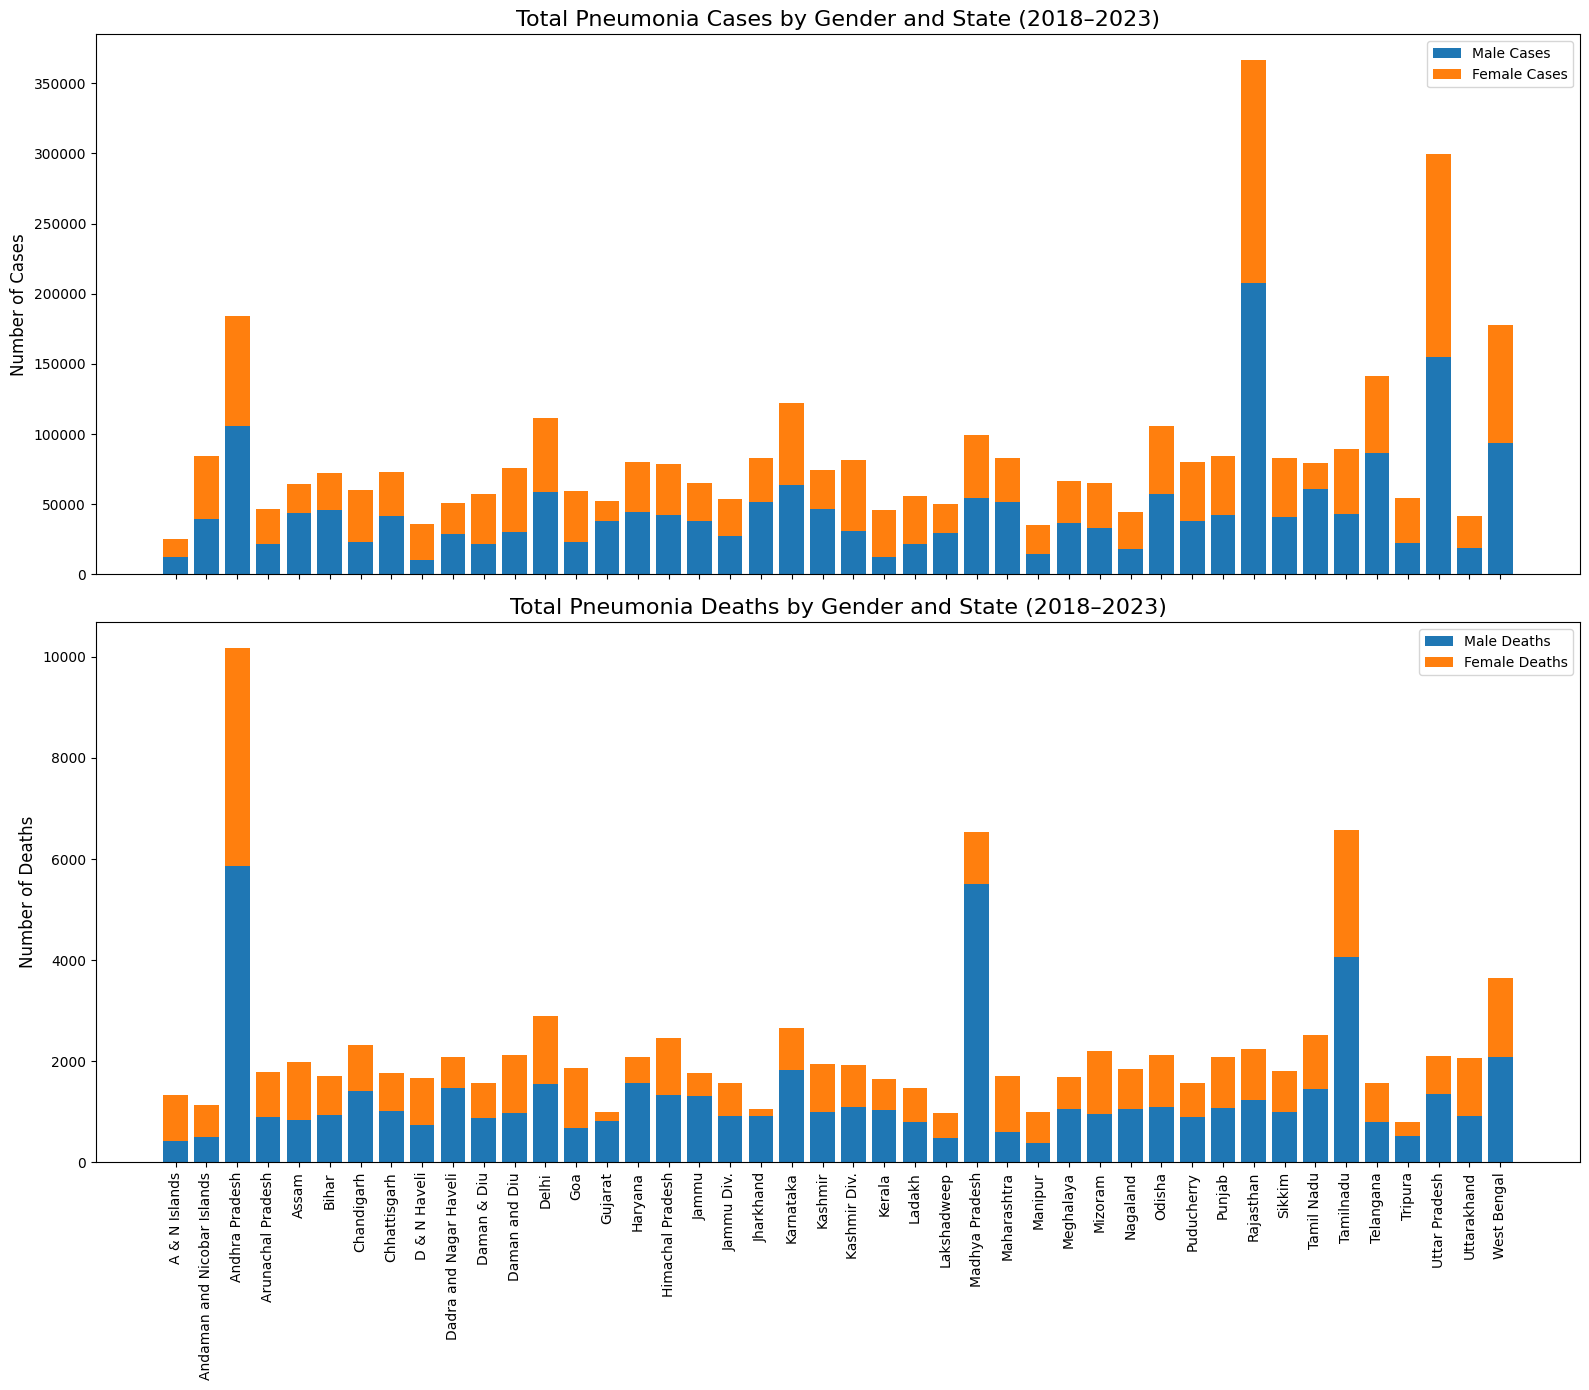

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True)

df_grouped = df12.groupby("State/UT")[["Male Cases", "Female Cases", "Male Deaths", "Female Deaths"]].sum().reset_index()

# Cases
axes[0].bar(df_grouped["State/UT"], df_grouped["Male Cases"], label="Male Cases", color="#1f77b4")
axes[0].bar(df_grouped["State/UT"], df_grouped["Female Cases"], bottom=df_grouped["Male Cases"], label="Female Cases", color="#ff7f0e")
axes[0].set_title("Total Pneumonia Cases by Gender and State (2018–2023)", fontsize=16)
axes[0].set_ylabel("Number of Cases", fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=90)

# Deaths
axes[1].bar(df_grouped["State/UT"], df_grouped["Male Deaths"], label="Male Deaths", color="#1f77b4")
axes[1].bar(df_grouped["State/UT"], df_grouped["Female Deaths"], bottom=df_grouped["Male Deaths"], label="Female Deaths", color="#ff7f0e")
axes[1].set_title("Total Pneumonia Deaths by Gender and State (2018–2023)", fontsize=16)
axes[1].set_ylabel("Number of Deaths", fontsize=12)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [130]:
# Grouping and sorting death data
state_deaths = df12.groupby("State/UT")[["Male Deaths", "Female Deaths"]].sum()
state_deaths["Total Deaths"] = state_deaths["Male Deaths"] + state_deaths["Female Deaths"]
top_deaths = state_deaths.sort_values("Total Deaths", ascending=False).head(4)
top_deaths_data = top_deaths[["Male Deaths", "Female Deaths"]]

labels = top_deaths_data.index.tolist()
male_cases = top_deaths_data["Male Deaths"].tolist()
female_cases = top_deaths_data["Female Deaths"].tolist()


In [131]:
labels += [labels[0]]
male_cases += [male_cases[0]]
female_cases += [female_cases[0]]

# radial chart
fig_male = go.Figure()
fig_male.add_trace(go.Scatterpolar(
    r=male_cases,
    theta=labels,
    fill='toself',
    name='Male Cases',
    line=dict(color='blue')
))
fig_male.update_layout(
    title='Male Pneumonia Cases - Top 4 States',
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=False
)
fig_male.show()

# Female cases radial chart
fig_female = go.Figure()
fig_female.add_trace(go.Scatterpolar(
    r=female_cases,
    theta=labels,
    fill='toself',
    name='Female Cases',
    line=dict(color='purple')
))
fig_female.update_layout(
    title='Female Pneumonia Cases - Top 4 States',
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=False
)
fig_female.show()

In [132]:
import plotly.graph_objects as go

# Extract labels and values
labels = top_deaths_data.index.tolist()
male_deaths = top_deaths_data["Male Deaths"].tolist()
female_deaths = top_deaths_data["Female Deaths"].tolist()

# Close the loop for radial plot
labels += [labels[0]]
male_deaths += [male_deaths[0]]
female_deaths += [female_deaths[0]]

# Create combined death chart
fig_deaths = go.Figure()

fig_deaths.add_trace(go.Scatterpolar(
    r=male_deaths,
    theta=labels,
    fill='toself',
    name='Male Deaths',
    line=dict(color='blue')
))

fig_deaths.add_trace(go.Scatterpolar(
    r=female_deaths,
    theta=labels,
    fill='toself',
    name='Female Deaths',
    line=dict(color='purple')
))

fig_deaths.update_layout(
    title='Pneumonia Deaths (Male & Female) - Top 4 States',
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True
)

fig_deaths.show()


# **7. CHIKUNGUNYA**

In [133]:
df13=pd.read_csv('state-and-year-wise-chikungunya-cases-suspected-and-confirmed-in-india.csv')

In [134]:
df13.drop(['unit','note'], axis=1, inplace=True)

In [135]:
df13.head(10)

,year,state,category,value
0,2024,Andhra Pradesh,Suspected,3242
1,2024,Arunachal Pradesh,Suspected,15
2,2024,Assam,Suspected,69
3,2024,Bihar,Suspected,264
4,2024,Chhattisgarh,Suspected,0
5,2024,Goa,Suspected,354
6,2024,Gujarat,Suspected,23941
7,2024,Haryana,Suspected,1669
8,2024,Himachal Pradesh,Suspected,55
9,2024,Jharkhand,Suspected,3853


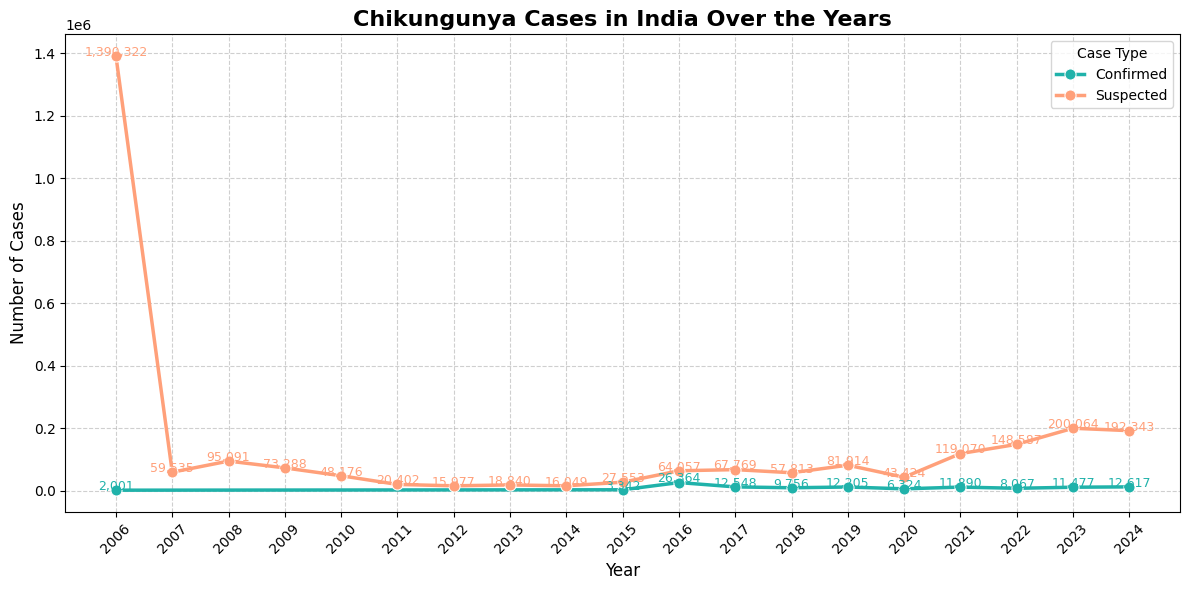

In [136]:
# Prepare data
df13_summary_by_year = df13.groupby(['year', 'category'])['value'].sum().reset_index()
df13_summary_by_year['year'] = df13_summary_by_year['year'].astype(str)  # Treat years as categories

# Plot
plt.figure(figsize=(12, 6))
palette = {"Suspected": "#FFA07A", "Confirmed": "#20B2AA"}
sns.lineplot(data=df13_summary_by_year, x='year', y='value', hue='category',
             marker='o', palette=palette, linewidth=2.5, markersize=8)

# Annotate data points
for _, row in df13_summary_by_year.iterrows():
    plt.text(row['year'], row['value'] + 500, f"{row['value']:,}",
             horizontalalignment='center', fontsize=9, color=palette[row['category']])

# Title and formatting
plt.title("Chikungunya Cases in India Over the Years", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend(title="Case Type")
plt.tight_layout()
plt.show()

/tmp/ipython-input-137-3550127461.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




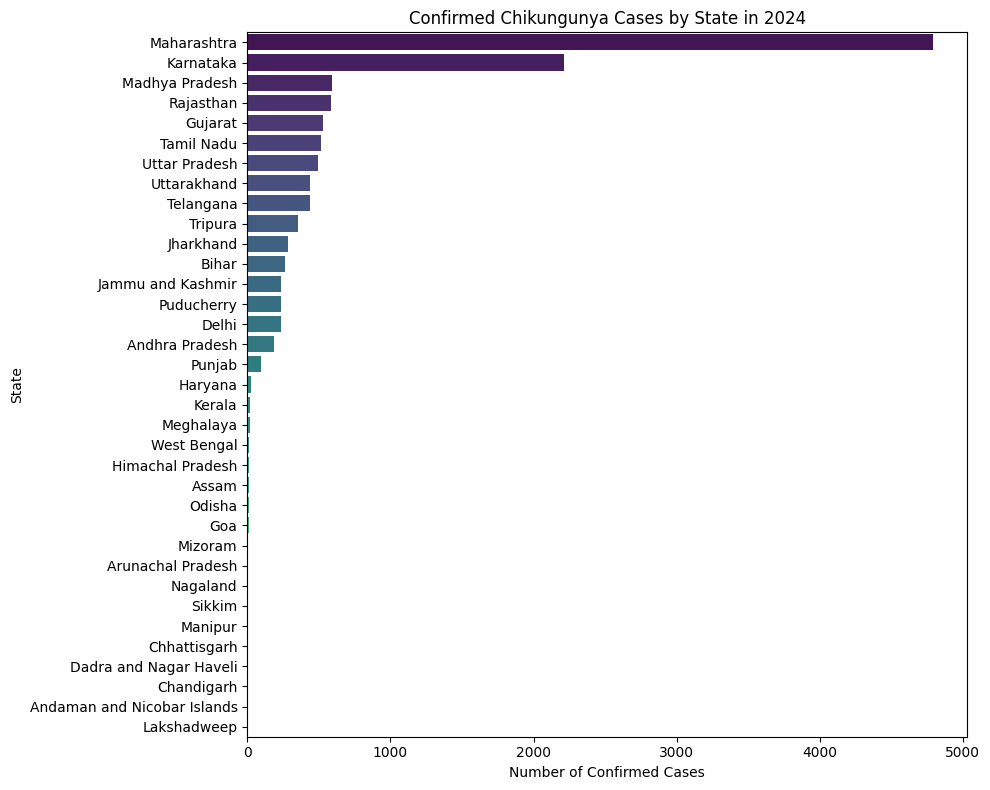

In [137]:
# Filter latest year
latest_year = df13['year'].max()
latest_data = df13[df13['year'] == latest_year]
confirmed_latest = latest_data[latest_data['category'] == 'Confirmed']

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=confirmed_latest.sort_values('value', ascending=False), y='state', x='value', palette='viridis')
plt.title(f"Confirmed Chikungunya Cases by State in {latest_year}")
plt.xlabel("Number of Confirmed Cases")
plt.ylabel("State")
plt.tight_layout()
plt.show()


/tmp/ipython-input-138-1639253375.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




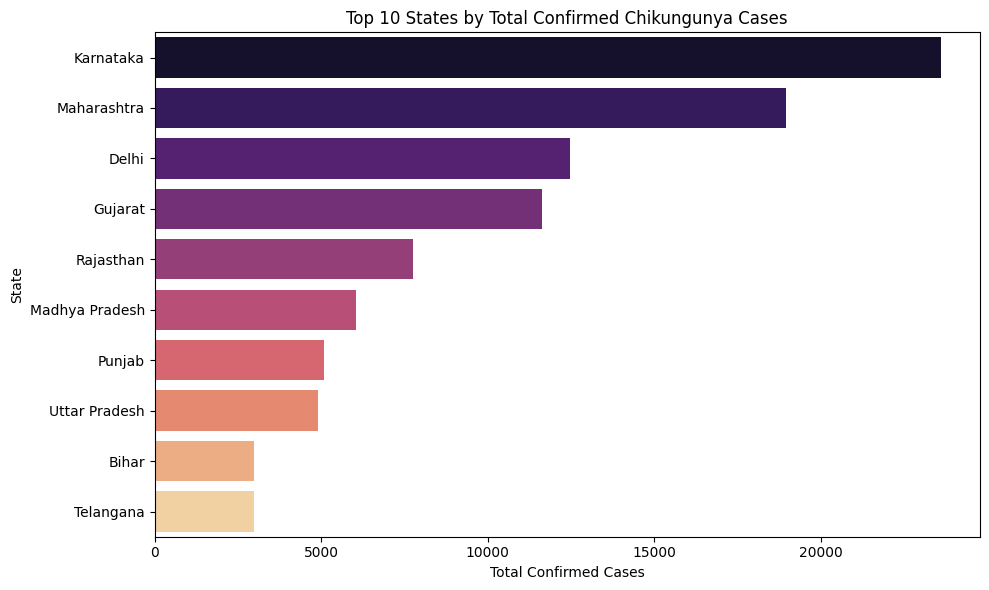

In [138]:
# Aggregate confirmed cases
total_confirmed_by_state = (
    df13[df13['category'] == 'Confirmed']
    .groupby('state')['value']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=total_confirmed_by_state.values, y=total_confirmed_by_state.index, palette='magma')
plt.title("Top 10 States by Total Confirmed Chikungunya Cases")
plt.xlabel("Total Confirmed Cases")
plt.ylabel("State")
plt.tight_layout()
plt.show()
